# infos

    A Insurance All fez uma pesquisa com cerca de 380 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

    O time de produtos selecionou 127 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas.

    Contudo, o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha.
    
   =============================================================================================
   
    Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

    Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

    E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

    Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

   =======================================================================================
    
    Explore os Dados usando ferramentas e testes Estatísticos com o objetivo de encontrar inconsistências dos dados e tratar possíveis dados faltantes.

    Levante Hipóteses sobre as características de transações legítimas e fraudulentas. Valide ou refute essas hipóteses através dos dados.

    Prepare os Dados para que os Algoritmos Estatísticos ou de Machine Learning sejam capazes de aprender a tarefa.

    Escreva vários algoritmos Classificadores.

    Contabilize a Performance do Modelo de Machine Learning e transforme em Performance de Negócio.

    Desenvolva uma API que retorne um “Score de Propensão” de compra para cada cliente, ou seja, uma probabilidade do cliente estar interessado em comprar um seguro de automóvel.

    Crie um README sobre como interpretar e usar a sua solução.

    Escreva um Relatório, respondendo às perguntas de negócio.

In [184]:
# terminal é bom devido aos comandos de inserção de dados *****************************

# dbeaver é bom para validar queries do/no jupyter notebook ou pegar informações rápidas sem precisar processar dados ******************


######################conexão específica para postgres no terminal

# instalar psql terminal ubuntu
# man psql = comando para abrir o manual do psql (ou main)
# psql -h comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com \   o \ é pra continuar da próxima linha
# > -p 5432 \           # testar sem todos os escapes
# > -d comunidadedsdb \
# > -U member \
# > -W cdspa

# agora dentro do database, encontrar schemas/tabelas

# \dn listar os schemas
# \dt pa004.*             comando p/ ver tabelas, como n se sabe as tabelas na primeira vez, passar o * q é um coringa
# \dt+ pa004.*            saber o tamanho das tabelas em mbs
# select * from pa004.users limit 10;
# \q sai do banco de dados



##################### comandos no dbeaver(linguagem sql)
# select nspname from pg_catalog.pg_namespace pn          para ver os schemas
# select tablename from pg_catalog.pg_tables where schemaname = 'pa004'           para ver as tabelas


#################### pelo python usar o sql alchemy/pandas  (psycopg2 específico para postgres)
# geralmente usar pandas , possue métodos de conexão com bancos

# não deixar as credenciais no jupyter notebook/não comitar as credenciais ***********************
# usar máscara pra esconder as credenciais

# sempre fechar o cursor (cursor.close()) e a conexão (conn.close()) **************************

# import psycopg2 as pg


# conn = pg.connect(user= password= gost= port= database=)
# query_table_users = ***
#     SELECT * FROM pa004.users...
#     LIMIT 10;
#     ****
# (primeiro criar a conexão e a query_tables_users)
# df=pd.read_sql(query_tables_users,conn)
# df.head()

# 0 **Imports**

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import scikitplot as skplt
import matplotlib.gridspec as gridspec
import warnings;   warnings.filterwarnings("ignore")
import xgboost as xgb
import lightgbm as lightgbm

from matplotlib            import pyplot  as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from pylab                 import rcParams
from IPython.display       import Image
from scipy                 import stats  as ss
from sklearn               import model_selection as ms
from sklearn               import preprocessing as pp
from sklearn               import ensemble        as en
from sklearn               import linear_model    as lm
from sklearn               import neighbors       as nh
from sklearn.tree          import DecisionTreeClassifier
from sklearn.metrics       import top_k_accuracy_score
from sklearn.metrics       import accuracy_score, f1_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

# pd.options.display.float_format = '{:,.2f}'.format

##  **0.1 Helper functions**

In [2]:
# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
#     sns.set_style("whitegrid")
#     plt.style.use("dark_background")
#     rcParams['figure.figsize'] = 28,10
        
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
#     pd.options.display.float_format = '{:,.2f}'.format
    
#     sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [3]:
# jupyter_settings()

## **0.2 Loading data**

In [4]:
df_insurance_raw=pd.read_csv('../data/insurance_202206101822.csv')
df_users_raw=pd.read_csv('../data/users_202206101824.csv')
df_vehicles_raw=pd.read_csv('../data/vehicle_202206101824.csv')

# merge
df_raw=pd.merge(df_insurance_raw,df_users_raw,how='left',on='id')
df_raw=pd.merge(df_raw,df_vehicles_raw,how='left',on='id')

## 0.3 Test separation

In [5]:
df_raw

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,40454.0,217,1,Male,44,28.0,26.0,1,> 2 Years,Yes
1,2,0,33536.0,183,0,Male,76,3.0,26.0,1,1-2 Year,No
2,3,0,38294.0,27,1,Male,47,28.0,26.0,1,> 2 Years,Yes
3,4,1,28619.0,203,0,Male,21,11.0,152.0,1,< 1 Year,No
4,5,1,27496.0,39,0,Female,29,41.0,152.0,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,30170.0,88,0,Male,74,26.0,26.0,1,1-2 Year,No
381105,381106,1,40016.0,131,0,Male,30,37.0,152.0,1,< 1 Year,No
381106,381107,1,35118.0,161,0,Male,21,30.0,160.0,1,< 1 Year,No
381107,381108,0,44617.0,74,0,Female,68,14.0,124.0,1,> 2 Years,Yes


In [6]:
X=df_raw.drop('response',axis=1)
y=df_raw['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X,y,test_size=0.20,random_state=42)

df_raw=pd.concat ([x_train, y_train], axis=1) 

df_raw=df_raw.reset_index(drop=True)

# **Step 1 Data description**

In [191]:
df1=df_raw.copy()

In [192]:
df1

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,response
0,332804,0,52906.0,227,Female,39,15.0,55.0,1,1-2 Year,Yes,1
1,116249,0,23038.0,29,Male,38,11.0,26.0,1,1-2 Year,Yes,0
2,255006,1,45318.0,166,Male,22,30.0,152.0,1,< 1 Year,No,0
3,317475,1,29132.0,277,Female,23,41.0,151.0,1,< 1 Year,No,0
4,344213,0,2630.0,155,Male,56,48.0,154.0,1,> 2 Years,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
304882,259179,1,22575.0,287,Female,24,36.0,152.0,1,< 1 Year,No,0
304883,365839,0,41287.0,298,Male,56,35.0,124.0,1,1-2 Year,Yes,0
304884,131933,0,18857.0,76,Female,22,2.0,152.0,1,< 1 Year,Yes,0
304885,146868,1,2630.0,51,Male,44,32.0,156.0,1,1-2 Year,Yes,0


## **1.1 Data types**

In [193]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

## **1.2 Change types**

In [194]:
df1['region_code']=df1['region_code'].astype('int64')
df1['policy_sales_channel']=df1['policy_sales_channel'].astype('int64')

## **1.3 Check NA**

In [195]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

In [ ]:
x_test.isna().sum()

## **1.4 Descriptive statistics**

In [196]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### **1.4.1 Numerical attributes**

In [197]:
# Central Tendency - mean, median 
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min () )).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190594.098072,190639.0,110021.963852,-0.000004,-1.199753
1,previously_insured,0.0,1.0,1.0,0.458373,0.0,0.498264,0.167088,-1.972094
2,annual_premium,2630.0,540165.0,537535.0,30571.851319,31675.0,17254.215590,1.853769,36.695689
3,vintage,10.0,299.0,289.0,154.272609,154.0,83.642252,0.004656,-1.199888
4,age,20.0,85.0,65.0,38.835582,36.0,15.509496,0.670000,-0.570016
5,region_code,0.0,52.0,52.0,26.413340,28.0,13.217997,-0.117479,-0.863585
6,policy_sales_channel,1.0,163.0,162.0,111.966591,131.0,54.229980,-0.897379,-0.976093
7,driving_license,0.0,1.0,1.0,0.997829,1.0,0.046547,-21.390677,455.564047
8,response,0.0,1.0,1.0,0.121970,0.0,0.327251,2.310350,3.337740


### **1.4.2 Categorical attributes**

In [198]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

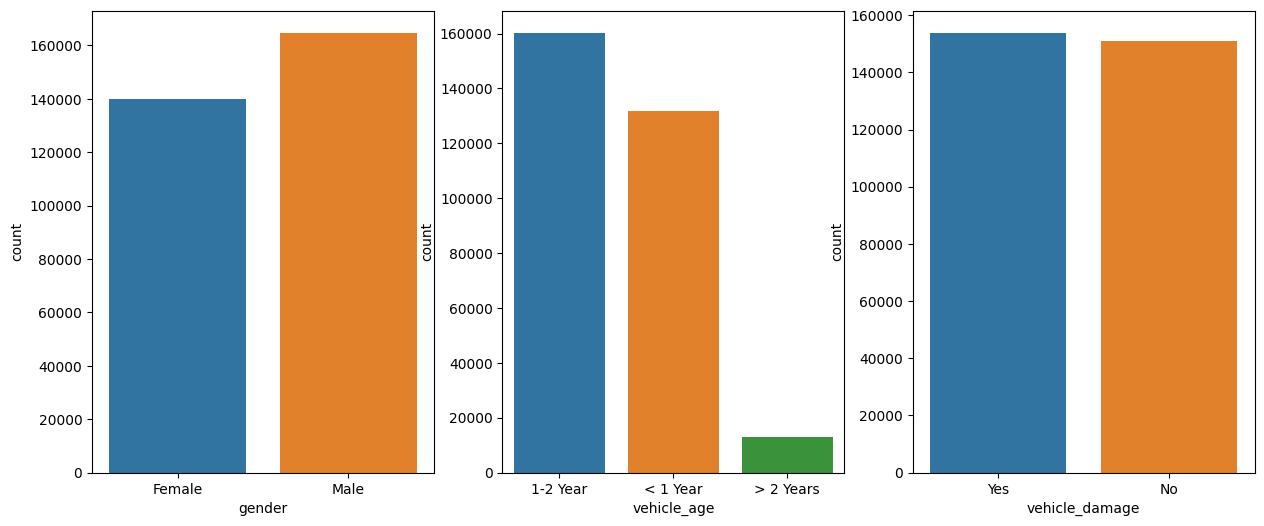

In [199]:
rcParams['figure.figsize'] = 15,6

plt.subplot(1,3,1);
sns.countplot(x='gender',data=df1);

plt.subplot(1,3,2);
sns.countplot(x='vehicle_age',data=df1);

plt.subplot(1,3,3);
sns.countplot(x='vehicle_damage',data=df1);

# **Step 2 Feature ngineering**

In [200]:
df2=df1.copy()

In [201]:
# vehicle age
df2['vehicle_age']=df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' 
                                            else 'between_1_2_years' if x == '1-2 Year'
                                            else 'below_1_year')

df2['previously_insured']=df2['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

df2['driving_license']=df2['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')

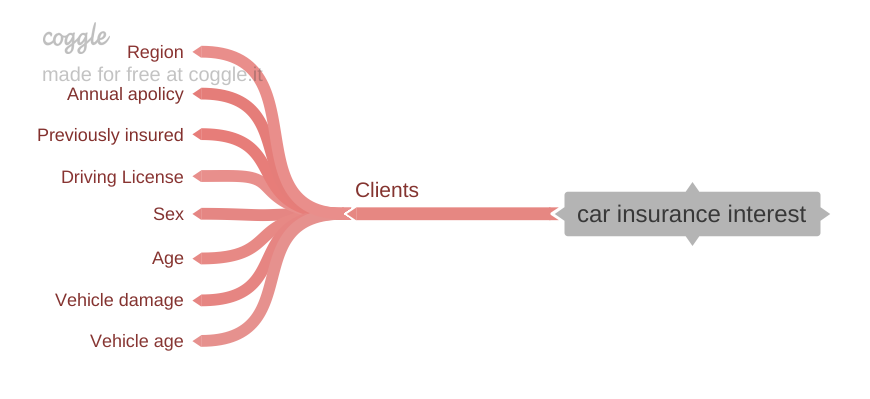

In [202]:
Image('../img/car_insurance_interest.png')

## **2.1 Hypothesis creation**

### **2.1.2 Clients**

**1** Quanto maior a apólice de saúde, maior a chance do interesse

**2** Se não tem seguro automotivo, maior chance de interesse

**3** Se tem carteira de motorista, maior chance de interesse

**4** Homens têm maior chance de se interessar

**5** Pessoas mais velhas têm mais chance de se interessar

**6** Proprietários de veículos mais novos têm maior chance de se interessar

**7** Pessoas que moram em regiões com mais acidentes e menos seguras têm mais chance de se interessar

**8** Pessoas há mais tempo associadas têm mais chance de se interessar

### **2.2 Feature engineering**

# **Step 3 Variable filtering**

In [203]:
df3=df2.copy()

## <s>**3.1 Row filtering**<s/>

## <s>**3.2 Column filtering**<s/>

# **Step 4 Exploratory data analysis**

In [204]:
df4=df3.copy()

## **4.1 Univariate analysis**

### **4.1.1 Response variable**

response
0    267700
1     37187
Name: count, dtype: int64

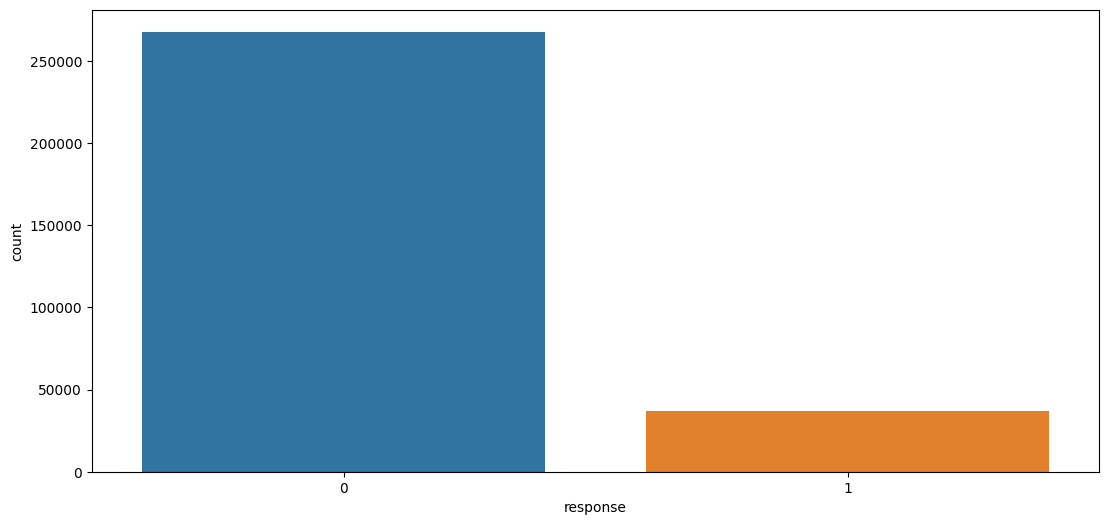

In [205]:
rcParams['figure.figsize'] = 13,6

sns.countplot(x='response',data=df4);
df4['response'].value_counts()

### **4.1.2 Numerical variables**

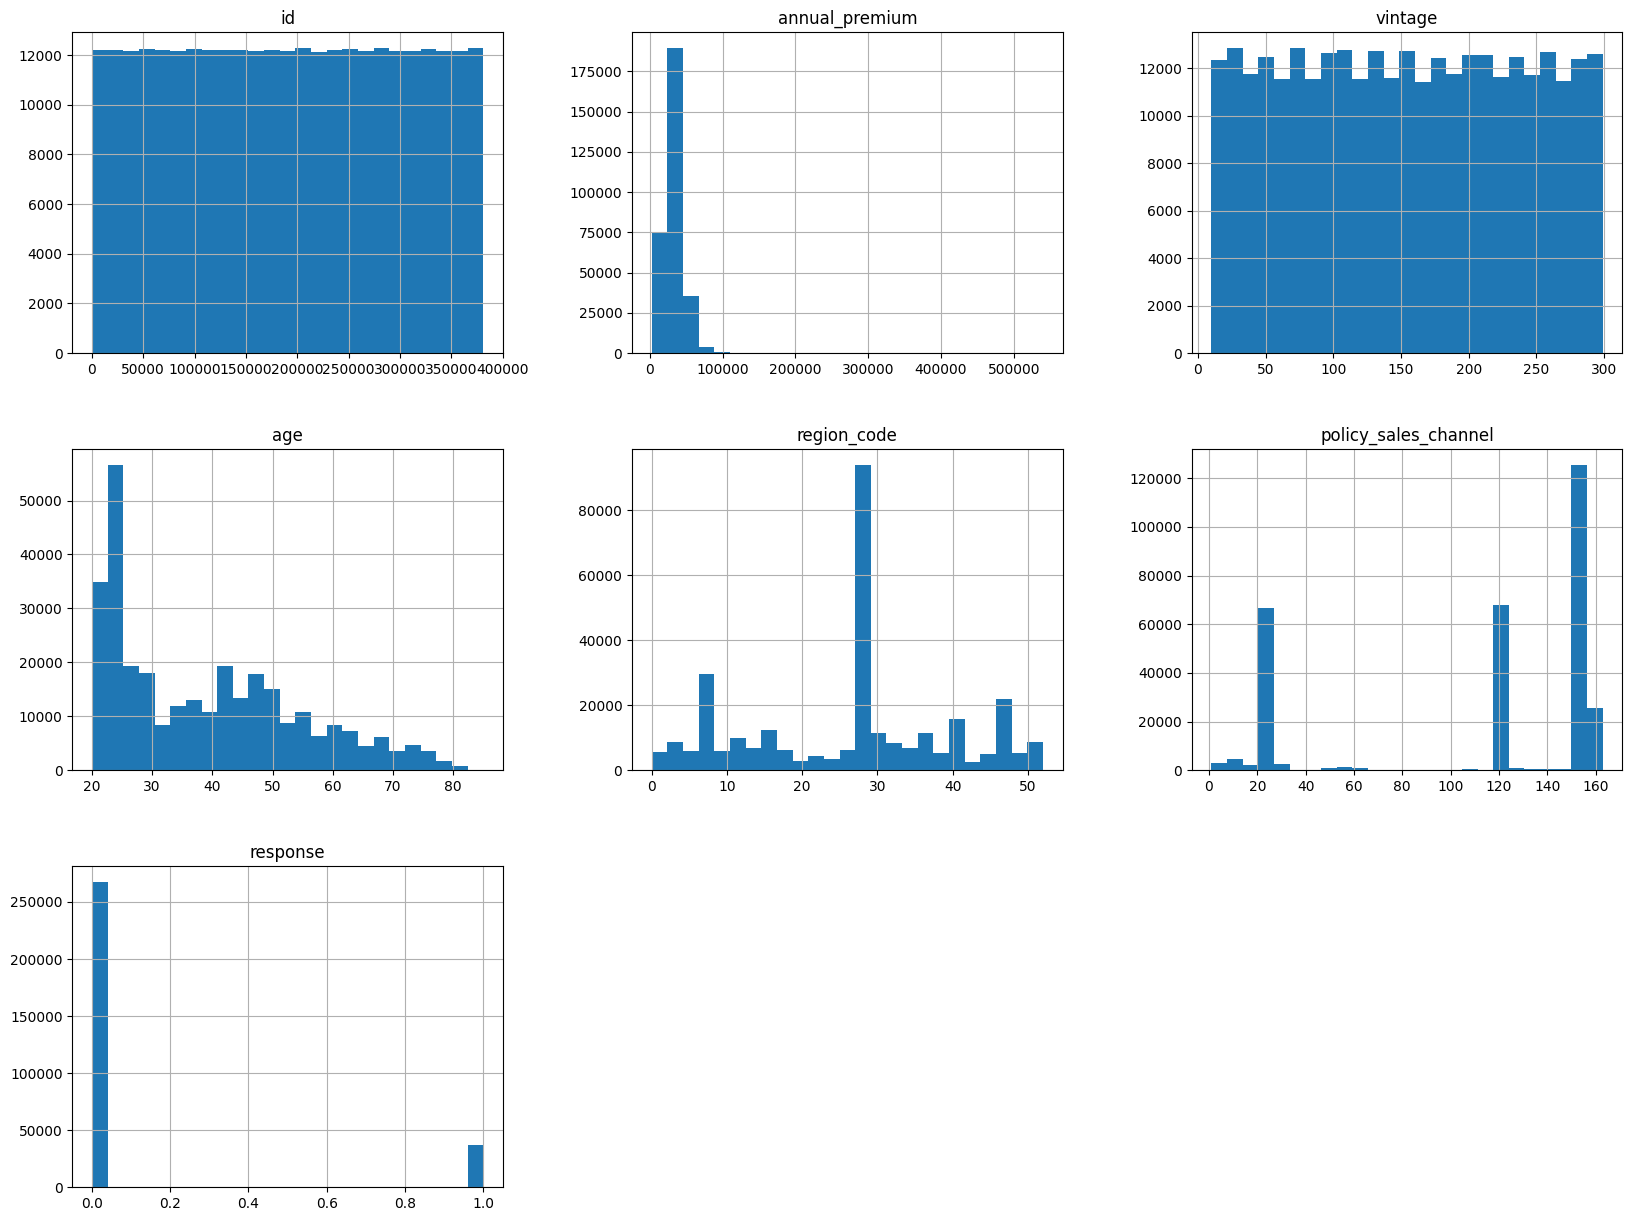

In [206]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64'])

rcParams['figure.figsize'] = 20,15
num_attributes.hist(bins=25);

### **4.1.3 Categorical variables**

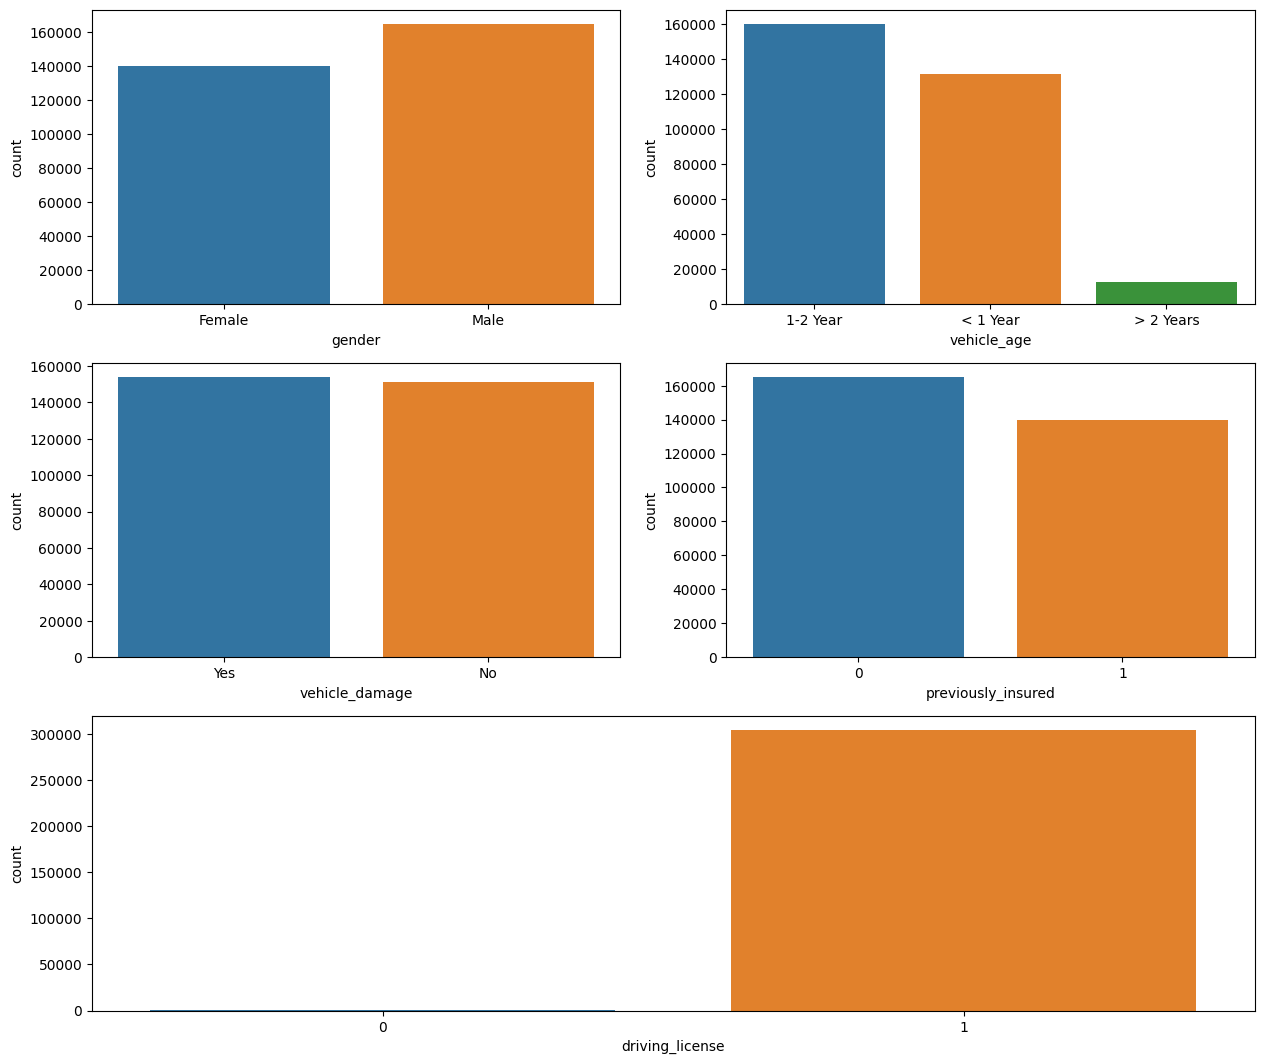

In [207]:
rcParams['figure.figsize'] = 15,13

grid=gridspec.GridSpec(3,2)

plt.subplot(grid[0,0])
# plt.subplot(1,3,1);
sns.countplot(x='gender',data=df1);

plt.subplot(grid[0,1])
# plt.subplot(1,3,2);
sns.countplot(x='vehicle_age',data=df1);

plt.subplot(grid[1,0])
# plt.subplot(1,3,3);
sns.countplot(x='vehicle_damage',data=df1);

plt.subplot(grid[1,1])
# plt.subplot(1,3,2);
sns.countplot(x='previously_insured',data=df1);

plt.subplot(grid[2,:])
# plt.subplot(1,3,3);
sns.countplot(x='driving_license',data=df1);

## **4.2 Bivariate analysis**


### **4.2.1 Annual_premium**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


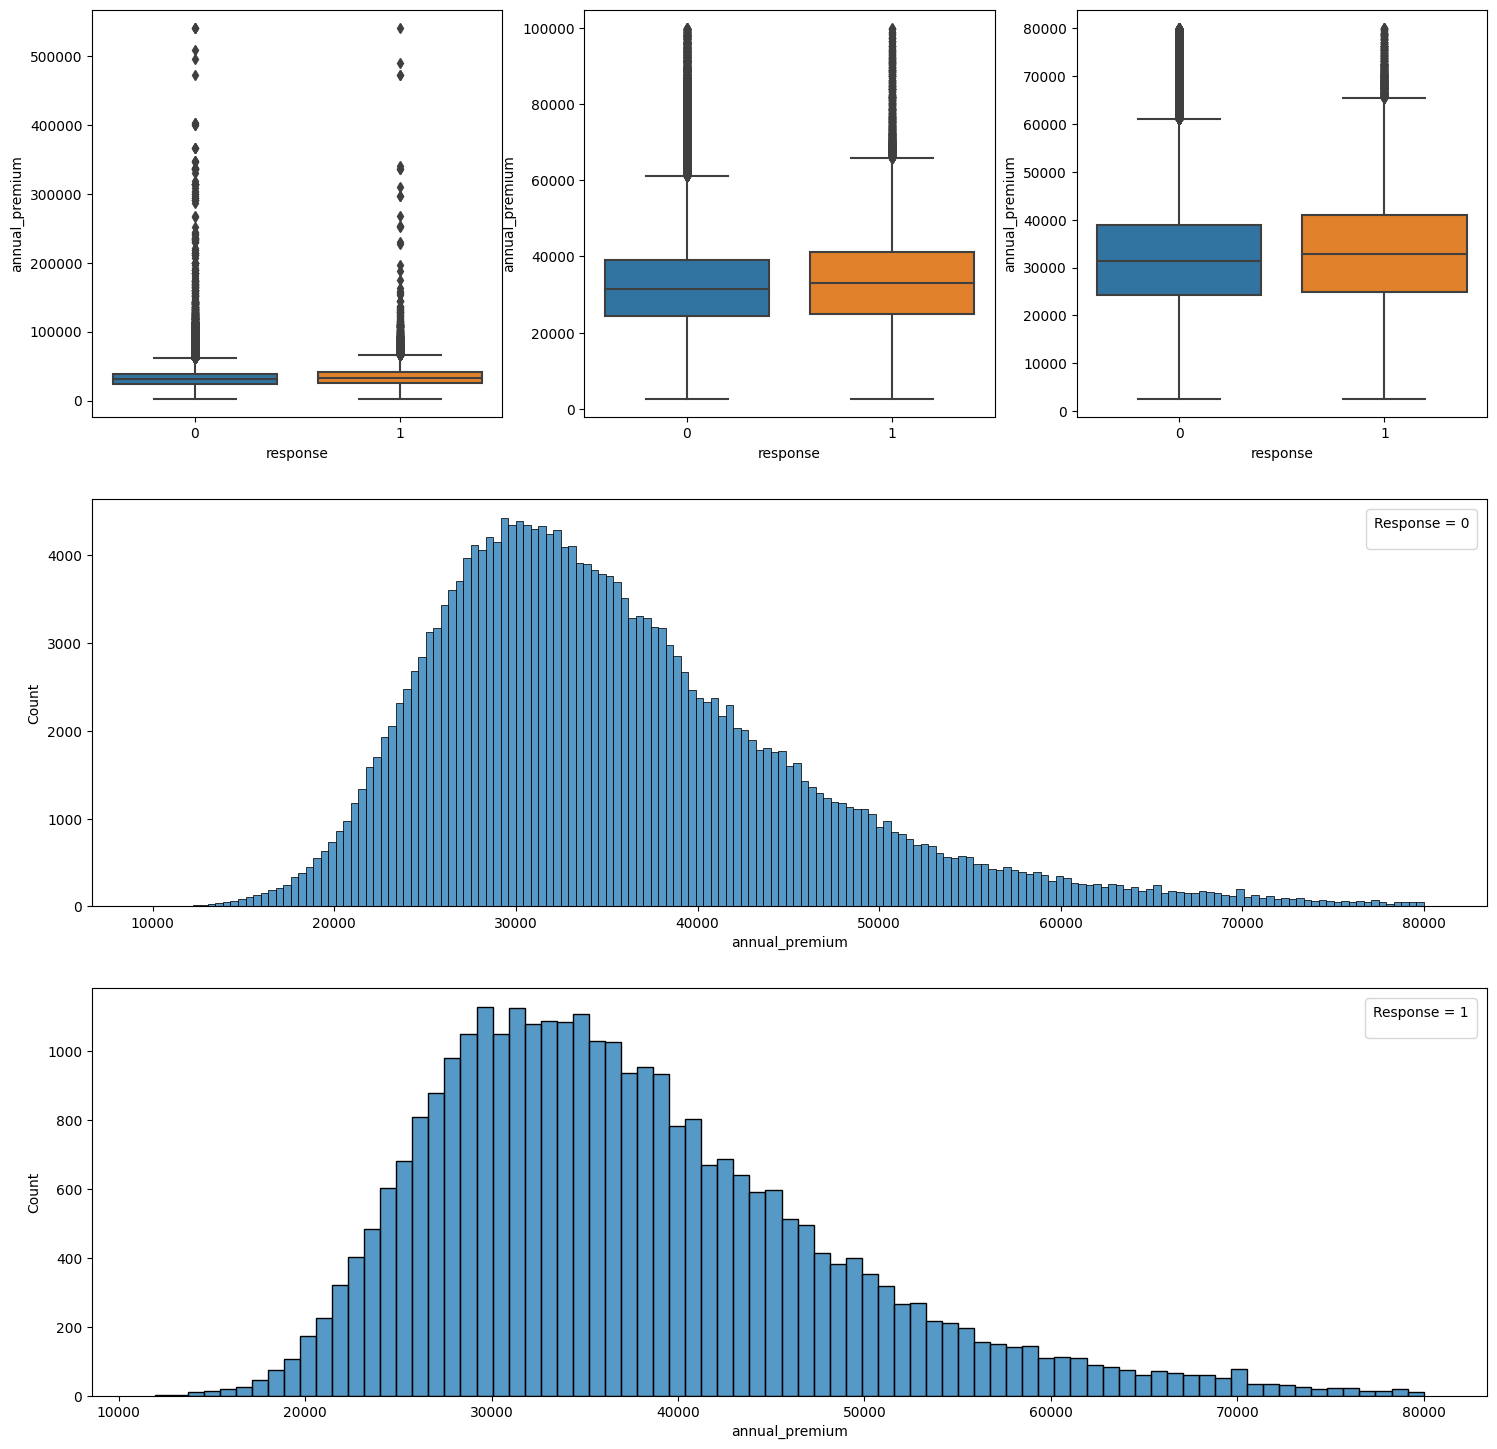

In [208]:
rcParams['figure.figsize'] = 18,18
grid=gridspec.GridSpec(3,3)


plt.subplot(grid[0,0])
sns.boxplot(x='response',y='annual_premium',data=df4); 

aux4=df4[df4['annual_premium'] < 100000]
plt.subplot(grid[0,1])
sns.boxplot(x='response',y='annual_premium',data=aux4);


aux4=df4[df4['annual_premium'] < 80000]
plt.subplot(grid[0,2])
sns.boxplot(x='response',y='annual_premium',data=aux4);


aux=df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00=aux.loc[df4['response']==0,'annual_premium']     
plt.subplot(grid[1,:])

plt.legend(title='Response = 0', fontsize="x-large")
sns.histplot(aux00);

aux00=aux.loc[df4['response']==1,'annual_premium'] 
plt.subplot(grid[2,:])
plt.legend(title='Response = 1', fontsize="x-large")
sns.histplot(aux00);

### **4.2.2 Vintage**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


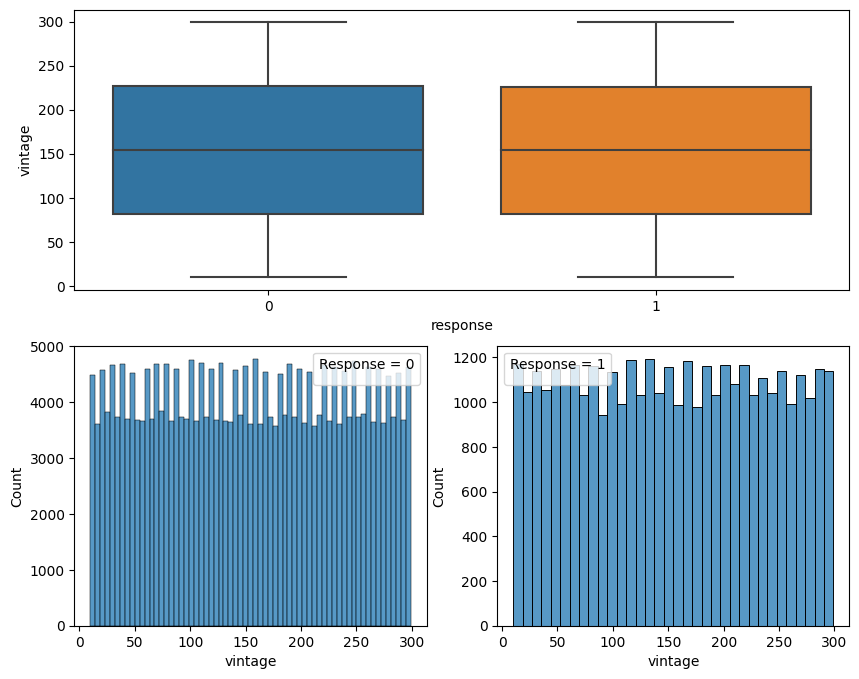

In [209]:
rcParams['figure.figsize'] = 10,8

grid=gridspec.GridSpec(2,2)

plt.subplot(grid[0,:])
sns.boxplot(x='response',y='vintage',data=df4);

plt.subplot(grid[1,0])
plt.legend(title='Response = 0')
sns.histplot(df4.loc[df4['response']==0,'vintage']);

plt.subplot(grid[1,1])
plt.legend(title='Response = 1')
sns.histplot(df4.loc[df4['response']==1,'vintage']);

### **4.2.3 Age**

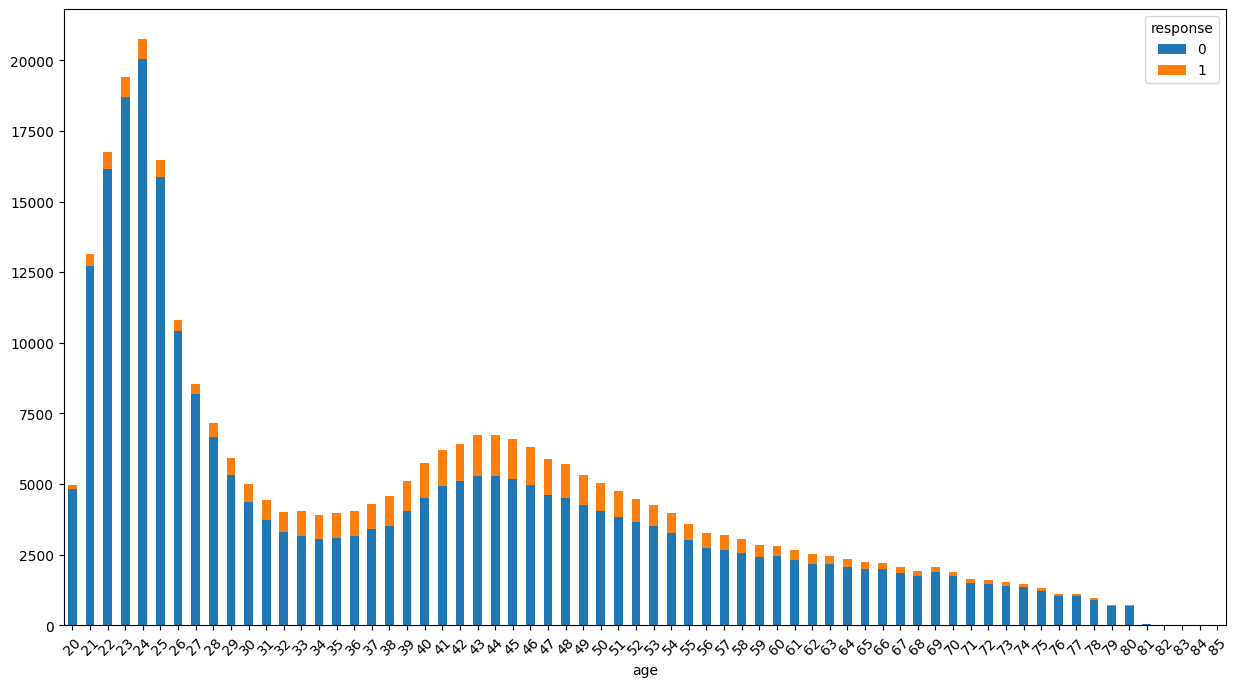

In [210]:
rcParams['figure.figsize'] = 15,8

# aux=df4[['id','age','response']].groupby(['age','response']).count().reset_index()
# sns.scatterplot(x='age',y='id',hue='response',data=aux);

crosstb=pd.crosstab(df4['age'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)
plt.xticks(rotation=45);

### **4.2.4 Region_code**

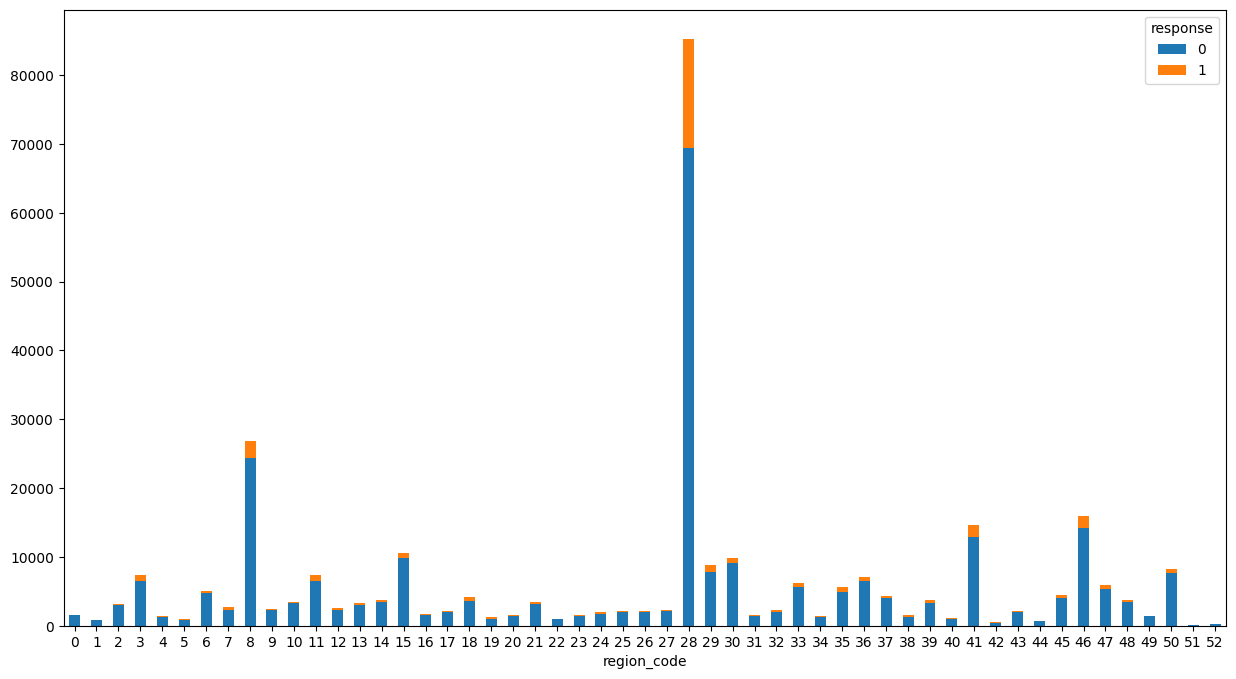

In [211]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['region_code'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [212]:
# rcParams['figure.figsize'] = 15,15

# grid=gridspec.GridSpec(2,2)

# plt.subplot(grid[0,:])
# aux0=df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
# sns.scatterplot(x='region_code',y='id',hue='response',data=aux0);

# # plt.subplot(grid[1,:])
# # sns.boxplot(x='response',y='region_code',data=df4);   # olhar a mediana/quartis/medianas de cada um dos grupos em relação a idade
# # 0 = 35 anos mediana, 1° ao 3° quartil : 25 a 50 anos


# plt.subplot(grid[1,0])
# aux00=df4.loc[df4['response']==0,'region_code']        # loc para passar a coluna como string
# plt.legend(title='Response = 0')
# sns.histplot(aux00);


# plt.subplot(grid[1,1])
# aux00=df4.loc[df4['response']==1,'region_code']        
# plt.legend(title='Response = 1')
# sns.histplot(aux00);

### **4.2.5 Policy_sales_channel**

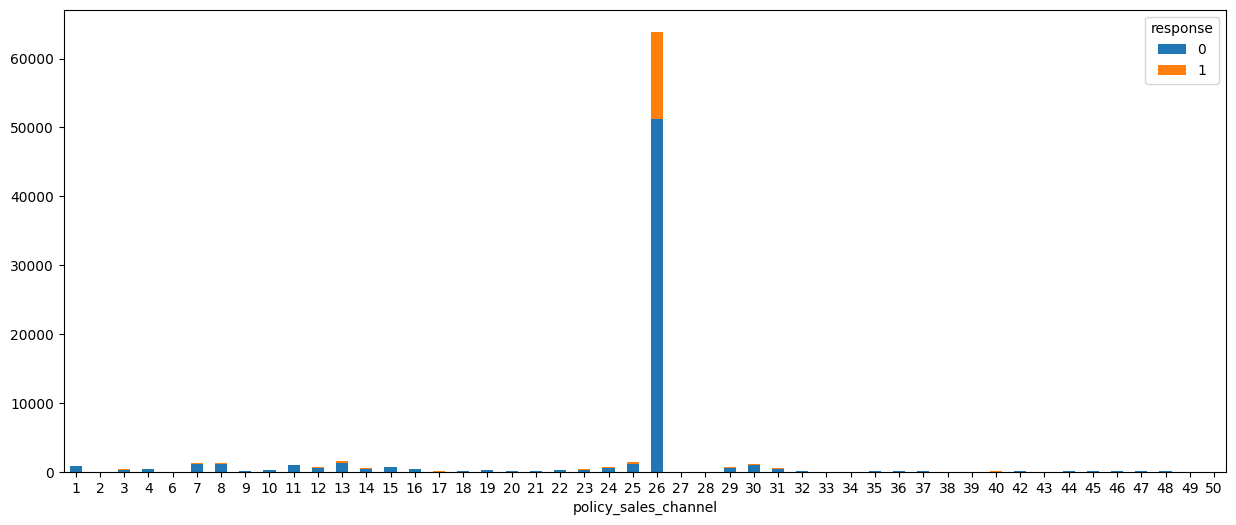

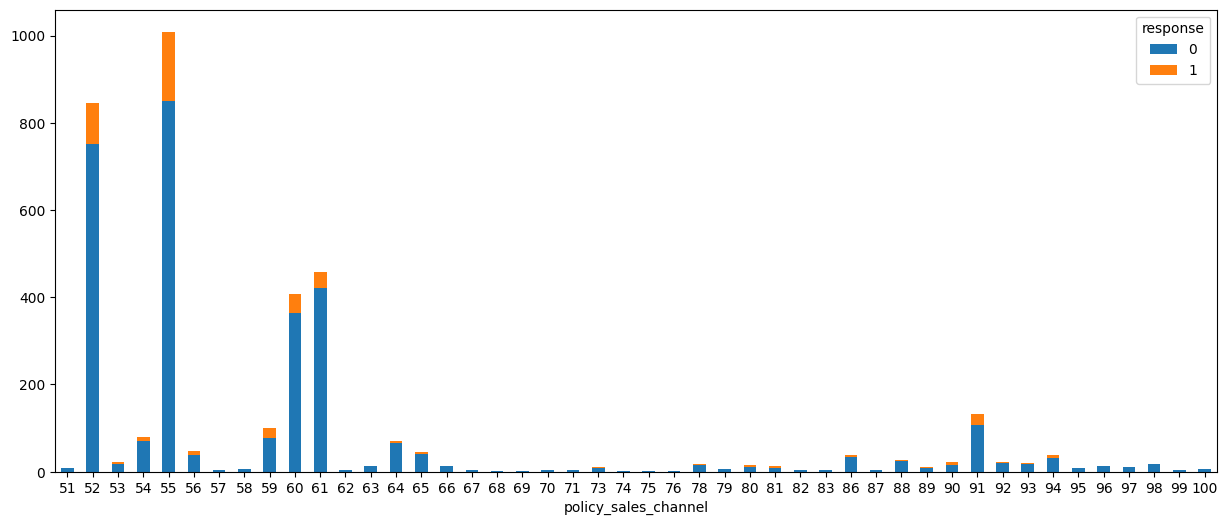

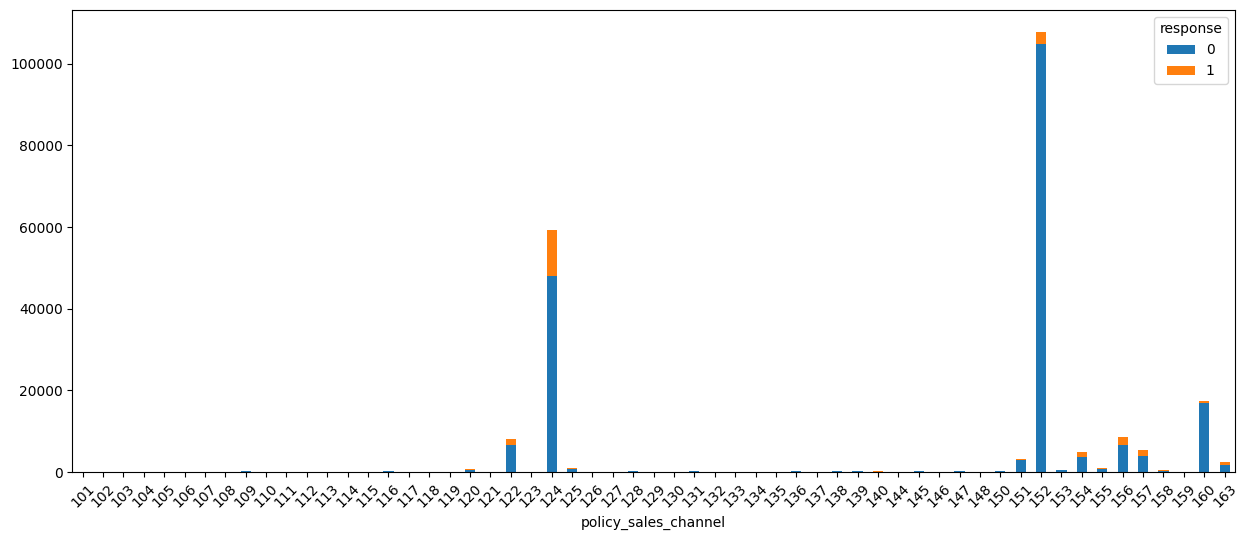

In [213]:
rcParams['figure.figsize'] = 15,6

aux=df4[df4['policy_sales_channel']<=50]
crosstb=pd.crosstab(aux['policy_sales_channel'],aux['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

aux1=df4[(df4['policy_sales_channel']>50) & (df4['policy_sales_channel']<=100)]
crosstb1=pd.crosstab(aux1['policy_sales_channel'],aux1['response'])
pl = crosstb1.plot(kind="bar", stacked=True, rot=0)


aux2=df4[df4['policy_sales_channel']>100]
crosstb2=pd.crosstab(aux2['policy_sales_channel'],aux2['response'])
pl = crosstb2.plot(kind="bar", stacked=True, rot=0)
plt.xticks(rotation=45);

In [214]:
# rcParams['figure.figsize'] = 15,8

# aux=df4[['policy_sales_channel','response']].groupby(['policy_sales_channel']).sum().reset_index()
# sns.barplot(x='response',y='policy_sales_channel',data=aux);
# plt.xticks(rotation=45);

# fazer o stacked percentage plot

### **4.2.6 Vehicle_age**

In [215]:
df4[['vehicle_age','response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_years,0,0.435227
1,below_1_year,0,0.413005
2,between_1_2_years,1,0.090781
3,over_2_years,0,0.029798
4,below_1_year,1,0.018827
5,over_2_years,1,0.012362


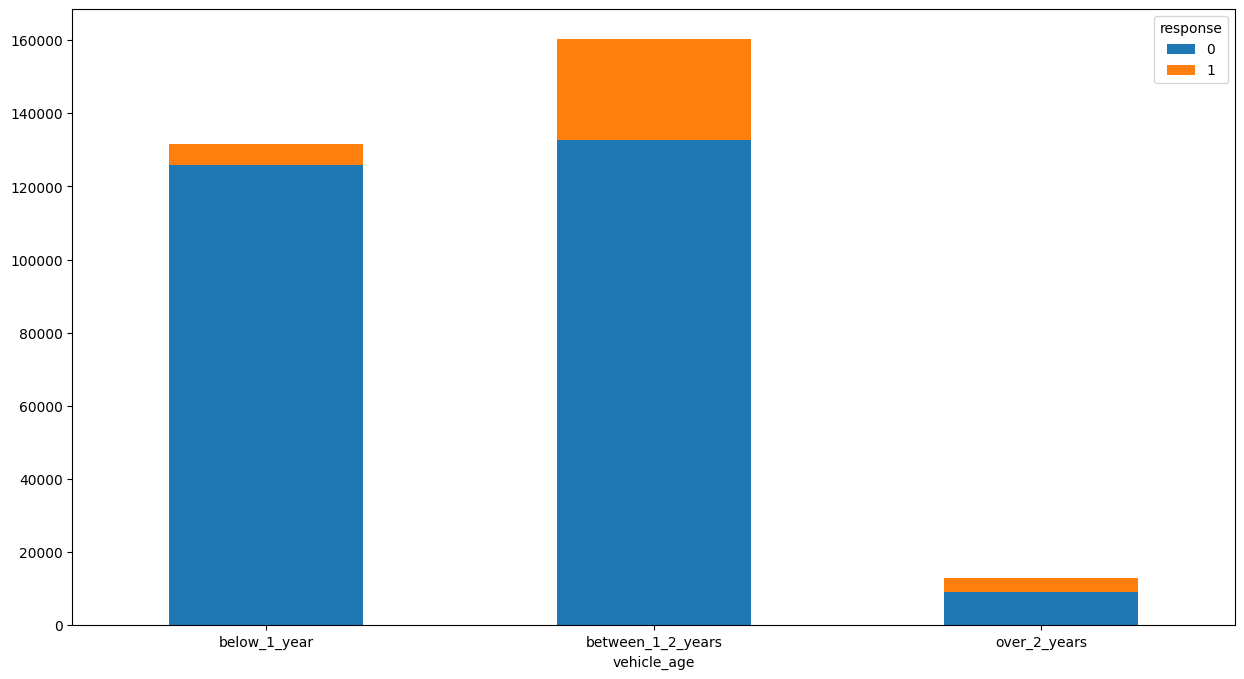

In [216]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['vehicle_age'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.7 Vehicle_damage**

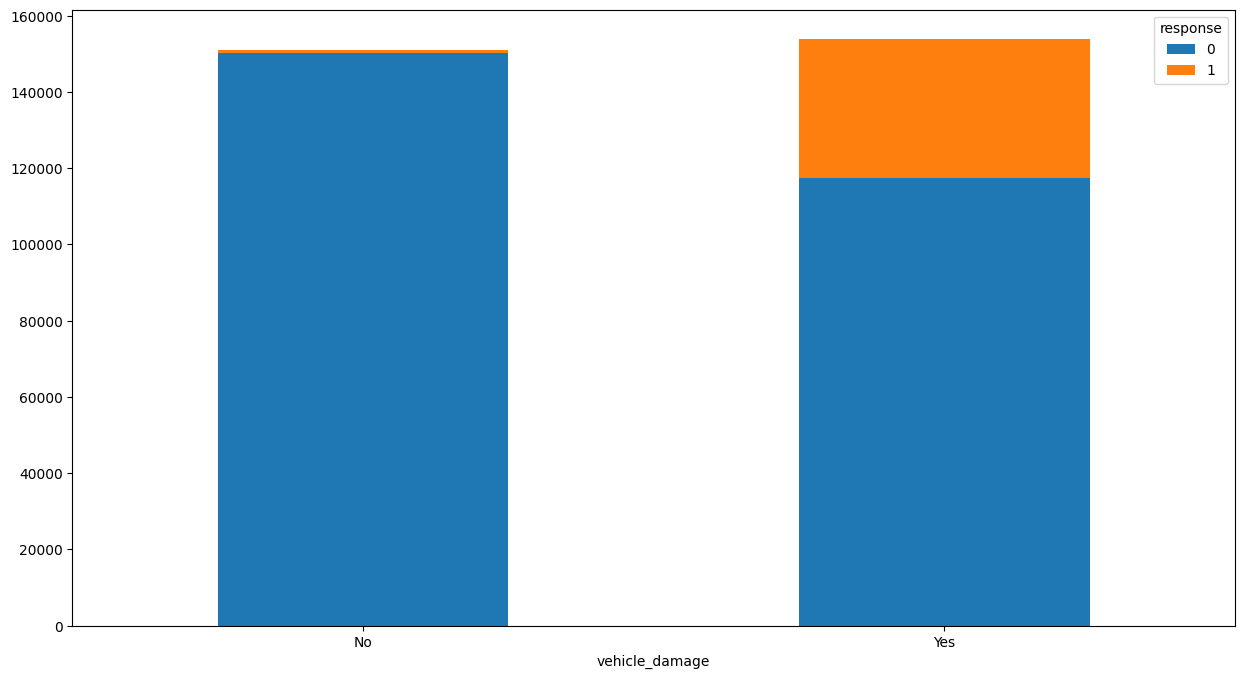

In [217]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['vehicle_damage'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.8 Previously_insured**

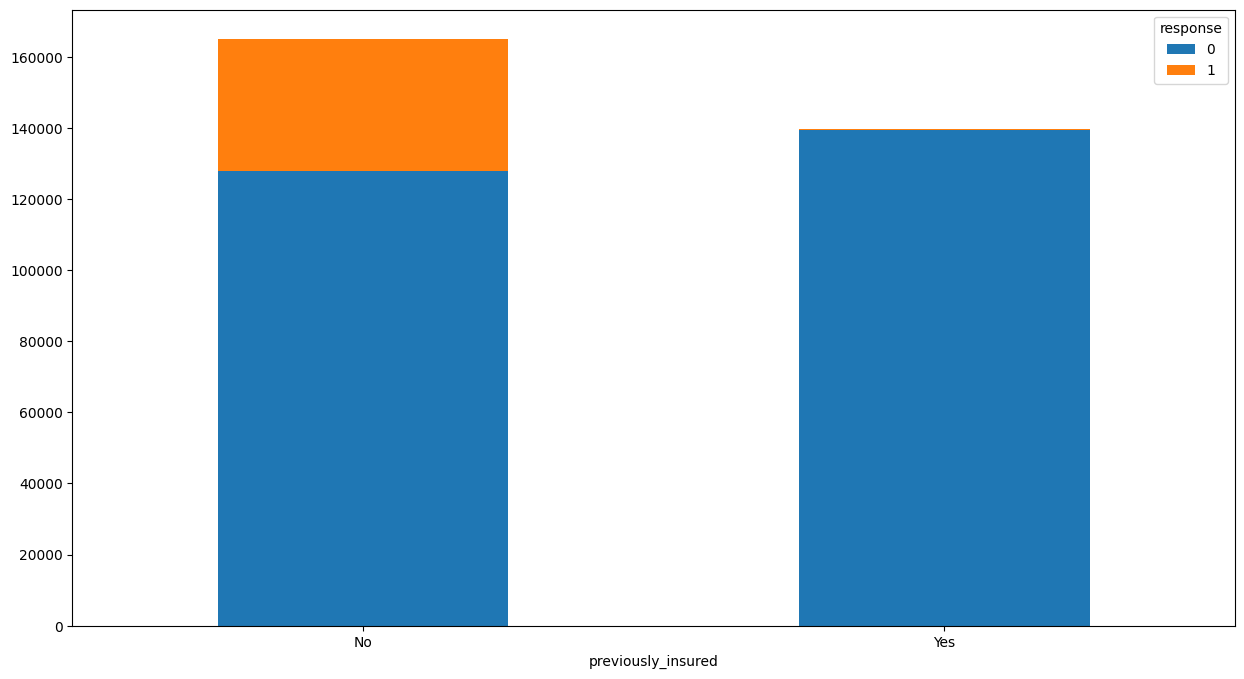

In [218]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['previously_insured'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [219]:
# pode ser um 'vazamento de dados' , pq é muito relacionado com a variável resposta (100% das pessoas q já tem, não querem), é como se fosse um if/else para o modelo

# pd.crosstab(df4['previously_insured'],df4['response']),'\n'

pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
previously_insured,,
No,0.775547,0.224453
Yes,0.999127,0.000873


### **4.2.9 Driving_license**

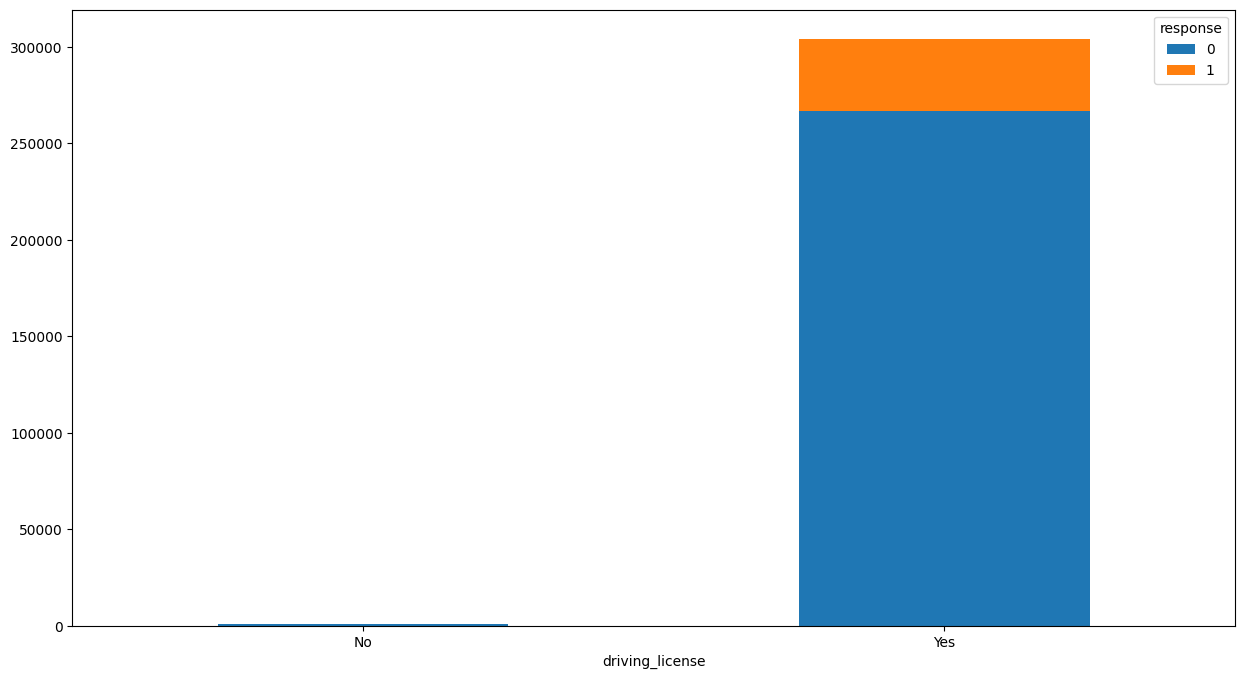

In [220]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['driving_license'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [221]:
pd.crosstab(df4['driving_license'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
driving_license,,
No,0.950151,0.049849
Yes,0.877873,0.122127


In [222]:
# plt.subplot(1,2,1)
# sns.countplot(df4['driving_license'])
# plt.subplot(2,2,2)
# aux1 = df4[['driving_license', 'response']].groupby( 'driving_license' ).sum().sort_values('response',ascending=False).reset_index()
# sns.barplot( x='driving_license', y='response', data=aux1 );

In [223]:
# soma agregada
# aux=df4[['driving_license','response']].groupby('response').sum().reset_index()
# # sns.barplot(x='response',y='driving_license',data=aux);

# aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
# aux

# 87% das pessoas que dirigem não querem o seguro = a variável é discriminativa porém precisa de outra junto

In [224]:
# print(pd.crosstab(df4['driving_license'],df4['response']),'\n')
# print(pd.crosstab(df4['driving_license'],df4['response']).apply(lambda x: x /x.sum(), axis=1))

## **hypos**

**1** Quanto maior a apólice de saúde, maior a chance do interesse

**2** Se não tem seguro automotivo, maior chance de interesse

**3** Homens têm maior chance de se interessar

**4** Pessoas mais velhas têm mais chance de se interessar

**5** Proprietários de veículos mais novos têm maior chance de se interessar

**6** Pessoas que moram em regiões com mais acidentes e menos seguras têm mais chance de se interessar

**7** Pessoas há mais tempo associadas têm mais chance de se interessar

### **H1 Quanto maior a apólice de saúde, maior a chance do interesse**

    falso

In [225]:
# print(df4['annual_premium'].value_counts().head(5))
# aux1=df4[['annual_premium','response']].groupby('annual_premium').sum().sort_values('response',ascending=False).reset_index()
# print(aux1.head())

In [226]:
# plt.subplot(1,2,1)
# sns.boxplot(x='response',y='annual_premium',data=df4);

# plt.subplot(1,2,2)
# x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **H2 Se não tem seguro automotivo, maior chance de interesse**

    verdadeiro

In [227]:
# aux2 = df4[['previously_insured', 'response']].groupby( 'previously_insured' ).sum().reset_index()
# aux2

In [228]:
# plt.subplot( 1, 3, 1 )
# aux2.hist(bins=25);
# # df4['previously_insured'].hist(bins=25);

# plt.subplot( 1, 3, 1 )
# df4['previously_insured'].hist(bins=25);

# plt.subplot( 1, 3, 2 )
# sns.barplot( x='previously_insured', y='response', data=aux2 );

# plt.subplot( 1, 3, 3 )
# x = sns.heatmap( aux2.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **H3 Homens têm maior chance de se interessar**

    verdadeiro

In [229]:
# aux3 = df4[['gender', 'response']].groupby( 'gender' ).sum().reset_index()
# aux3

In [230]:
# plt.subplot( 1, 2, 1 )
# df4['gender'].hist(bins=25);


# plt.subplot( 1, 2, 2 )
# sns.barplot( x='gender', y='response', data=aux3 );


# plt.subplot( 1, 3, 3 )
# x = sns.heatmap( aux3.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **H4 Pessoas mais velhas têm mais chance de se interessar**


    verdadeiro

In [231]:
# df4['age'].value_counts().head(20)
# aux4=df4[['age','response']].groupby('age').sum().sort_values('response',ascending=False).reset_index()
# aux4.head()

In [232]:
# plt.subplot( 1, 2, 1 )
# df4['age'].hist(bins=25);


# plt.subplot( 1, 2, 2 )
# sns.barplot( x='age', y='response', data=aux4 );
# plt.xticks( rotation=5 )


# plt.figure()
# x = sns.heatmap( aux4.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

In [233]:
# sns.boxplot(x='response',y='age',data=df4)

### **H5 Proprietários de veículos mais novos têm maior chance de se interessar**

In [234]:
# df4['vehicle_age'].value_counts()
# aux5=df4[['response','vehicle_age']].groupby('vehicle_age').sum().reset_index()
# aux5

In [235]:
# fig, (ax1,ax2) = plt.subplots(1,2)
# labels = '1-2 year', '< 1 year', '> 2 years'
# sizes = [200316, 164786, 16007]
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors);


# labels = '1-2 year', '< 1 year', '> 2 years'
# sizes = [34806, 7202, 4702]
# ax2.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors);


# plt.tight_layout()

### **H6 Pessoas que moram em regiões com mais acidentes e menos seguras têm mais chance de se interessar**

    falso

In [236]:
# df4['region_code'].value_counts().head(10)

In [237]:
# aux6=df4[['response','region_code']].groupby('region_code').sum().sort_values('response',ascending=False).reset_index()
# aux6.head(10)

In [238]:
# plt.subplot( 1, 2, 1 )
# df4['region_code'].hist(bins=25);

# plt.subplot( 1, 2, 2 )
# sns.barplot( x='region_code', y='response', data=aux6 );
# plt.xticks( rotation=5 );

# plt.figure()
# x = sns.heatmap( aux6.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **H7 Pessoas há mais tempo associadas têm mais chance de se interessar**

    falsa

In [239]:
# df4['vintage'].value_counts().head(10)

In [240]:
# aux7=df4[['response','vintage']].groupby('vintage').sum().sort_values('response',ascending=False).reset_index()
# aux7.head(10)

In [241]:
# sns.boxplot(x='response',y='vintage',data=df4);

In [242]:
# plt.subplot( 1, 3, 1 )
# df4['vintage'].hist(bins=25);

# plt.subplot( 1, 3, 2 )
# sns.barplot( x='vintage', y='response', data=aux7 );

# plt.subplot( 1, 3, 3 )
# x = sns.heatmap( aux7.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **4.2.1 Resumo das hipóteses**

## **4.3 Multivariate analysis**

### **4.3.1 Numerical attributes**

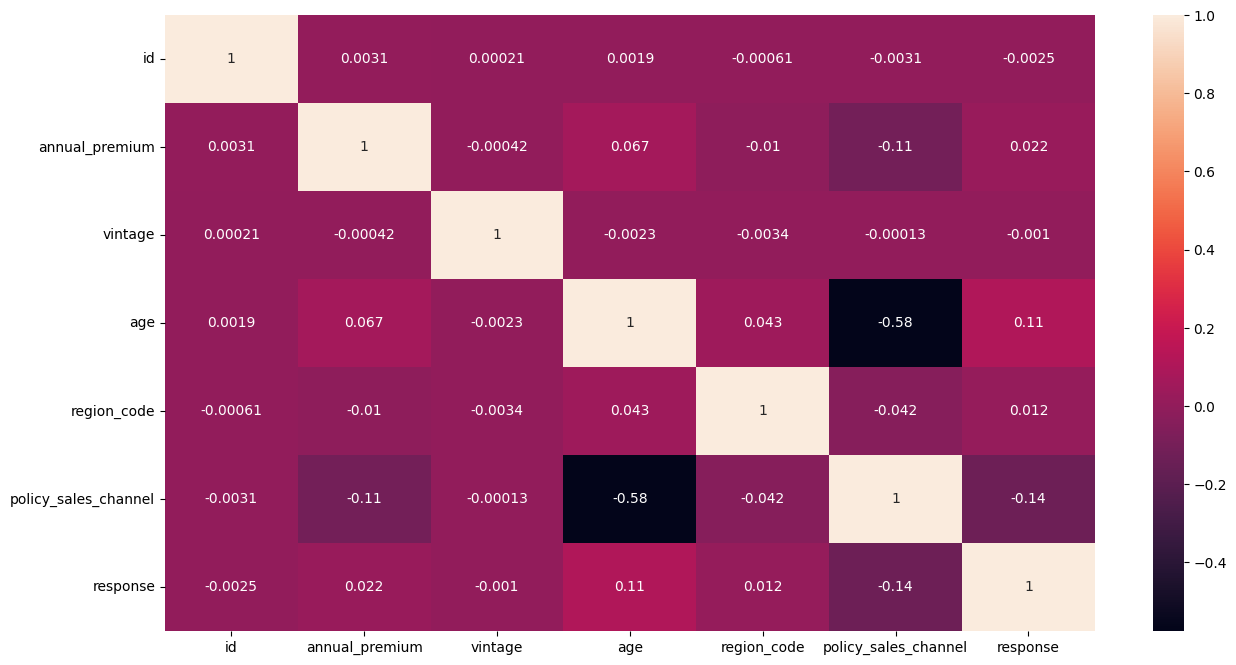

In [243]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

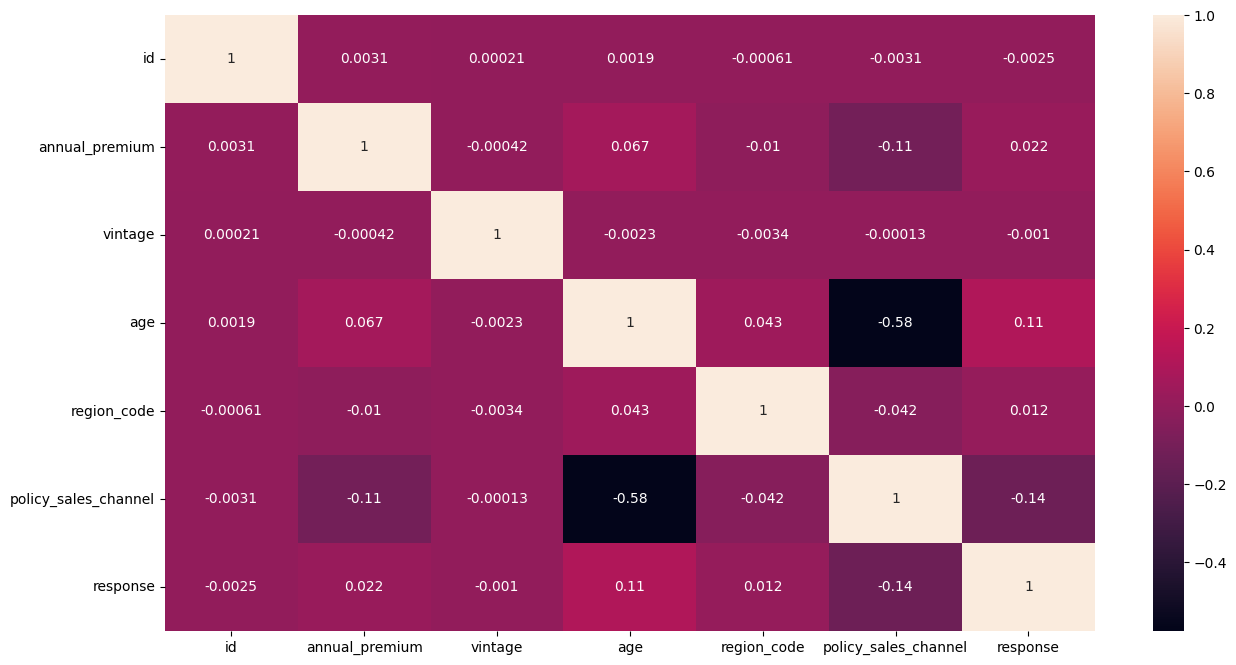

In [244]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

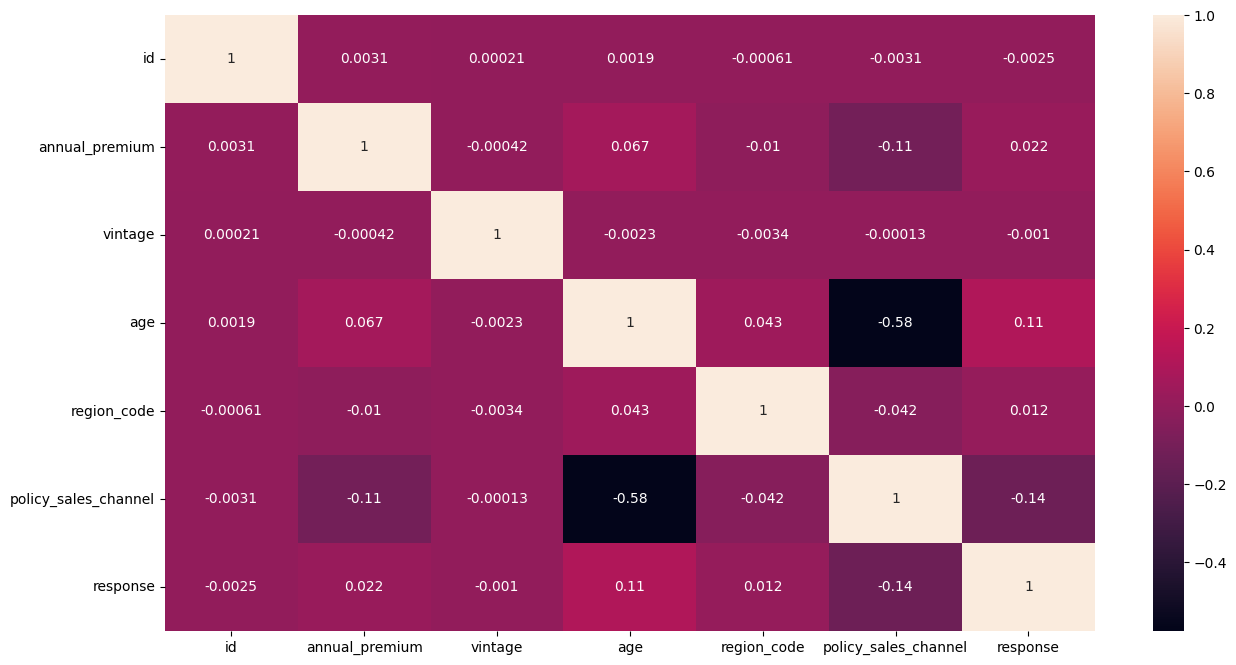

In [245]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### **4.3.2 Categorical attributes**

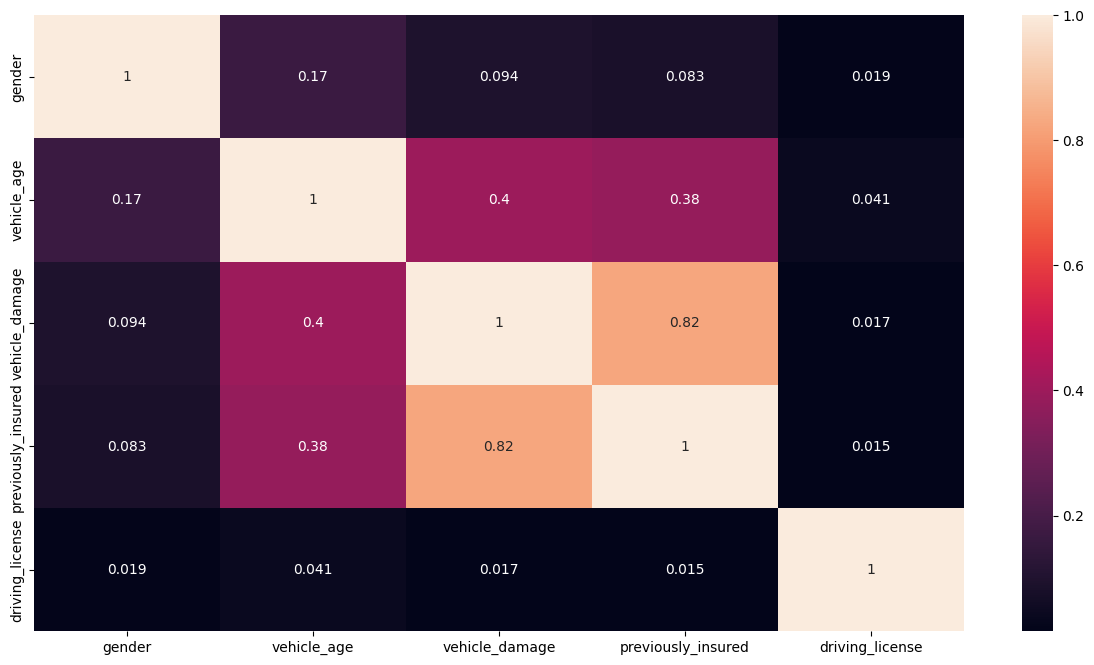

In [246]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )
a4 = cramer_v( a['gender'], a['previously_insured'] )
a5 = cramer_v( a['gender'], a['driving_license'] )

a6 = cramer_v( a['vehicle_age'], a['gender'] )
a7 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a8 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )
a9 = cramer_v( a['vehicle_age'], a['previously_insured'] )
a10 = cramer_v( a['vehicle_age'], a['driving_license'] )

a11 = cramer_v( a['vehicle_damage'], a['gender'] )
a12 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a13 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )
a14 = cramer_v( a['vehicle_damage'], a['previously_insured'] )
a15 = cramer_v( a['vehicle_damage'], a['driving_license'] )

a16 = cramer_v( a['previously_insured'], a['gender'] )
a17 = cramer_v( a['previously_insured'], a['vehicle_age'] )
a18 = cramer_v( a['previously_insured'], a['vehicle_damage'] )
a19 = cramer_v( a['previously_insured'], a['previously_insured'] )
a20 = cramer_v( a['previously_insured'], a['driving_license'] )

a21 = cramer_v( a['driving_license'], a['gender'] )
a22 = cramer_v( a['driving_license'], a['vehicle_age'] )
a23 = cramer_v( a['driving_license'], a['vehicle_damage'] )
a24 = cramer_v( a['driving_license'], a['previously_insured'] )
a25 = cramer_v( a['driving_license'], a['driving_license'] )

# Final dataset
d = pd.DataFrame( {'gender':          [a1, a2, a3, a4, a5], 
                   'vehicle_age':     [a6, a7, a8, a9, a10],
                   'vehicle_damage':  [a11, a12, a13, a14, a15],  
                'previously_insured': [a16, a17, a18, a19, a20],
                   'driving_license': [a21, a22, a23, a24, a25]})

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# **Step 5 Data preparation**

In [7]:
df4=pd.read_csv('df4',low_memory=False)
df5=df4.copy()

In [9]:
# encontrar o poder de generalização pq vai usar dados q o modelo nunca viu

X=df5.drop('response',axis=1)
y=df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20,random_state=42)

df5=pd.concat ([x_train, y_train], axis=1) # se torna o dataset de treino

### 5.0.1 Numerical plots

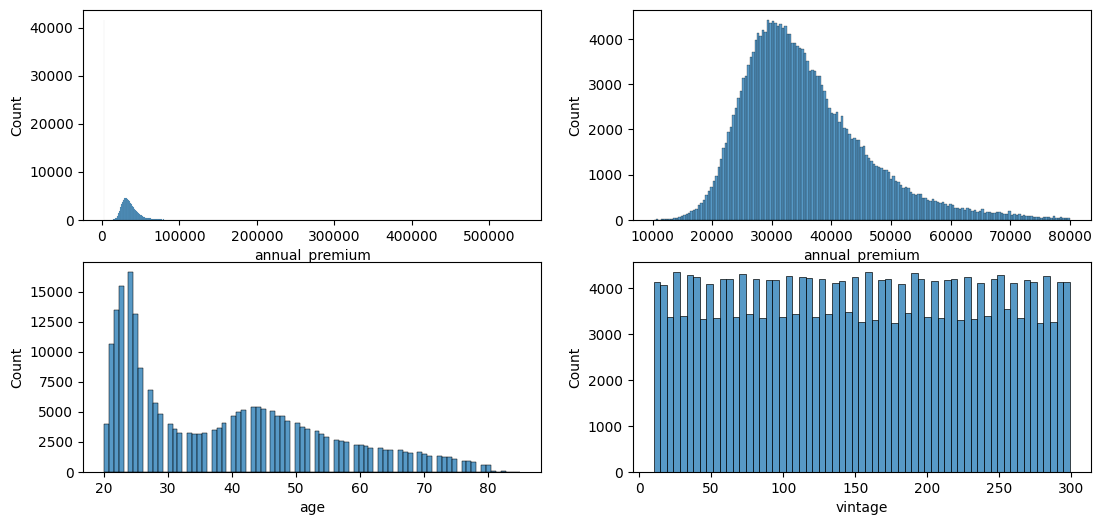

In [10]:
rcParams['figure.figsize'] = 13,6

plt.subplot(2,2,1)
sns.histplot(df5['annual_premium']);

plt.subplot(2,2,2)
aux=df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00=aux.loc[df4['response']==0,'annual_premium']        
sns.histplot(aux00);

plt.subplot(2,2,3)
sns.histplot(df5['age']); # plota a predominância ( 25 mil exemplos [não interessados])
# não é próxima de uma normal, por isso rescaling

plt.subplot(2,2,4)
sns.histplot(df5['vintage']);
# não possue distribuição

## **5.1 Standardization**

In [11]:
# ANNUAL_PREMIUM

ss=pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values) # duplo colchetes p/ pegar o array -sempre passar como array nos encoders

x_validation['annual_premium']=ss.transform(x_validation[['annual_premium']].values)

## **5.2 Rescaling**

In [12]:
# AGE

mms_age=pp.MinMaxScaler()

df5['age']=mms_age.fit_transform(df5[['age']].values)
x_validation['age']=mms_age.transform(x_validation[['age']].values)

# VINTAGE

mms_vintage=pp.MinMaxScaler()
df5['vintage']=mms_vintage.fit_transform(df5[['vintage']].values)
x_validation['vintage']=mms_vintage.transform(x_validation[['vintage']].values)

## **5.3 Encoder**

In [13]:
# GENDER
# target_encode_gender=df5.groupby('gender')['response'].mean()
# df5.loc[:,'gender']=df5['gender'].map(target_encode_gender)

df5=pd.get_dummies(df5,prefix='gender',columns=['gender'])
x_validation=pd.get_dummies(x_validation,prefix='gender',columns=['gender'])


# REGION_CODE
#  frequency encoding / target encoding / weighted target encoding

target_encode_region_code=df5.groupby('region_code')['response'].mean()
df5['region_code']=df5['region_code'].map(target_encode_region_code)  # mapear a representatividade em termos de frequência
x_validation['region_code']=x_validation['region_code'].map(target_encode_region_code) 


# VEHICLE_AGE
# pode usar order encoding/one hot encoding/frequency encoding, correndo o risco de desconsiderar carros com 2 meses ou 15 meses por exemplo
# get dummies do pandas = one hot encoding, dummies é melhor por já entregar as colunas mapeadas

df5=pd.get_dummies(df5,prefix='vehicle_age',columns=['vehicle_age'])
x_validation=pd.get_dummies(x_validation,prefix='vehicle_age',columns=['vehicle_age'])


# POLICY_SALES_CHANNEL

# target encoding/frequency encoding

fe_policy_sales_channel=df5.groupby('policy_sales_channel').size()/len(df5)  # (quantos exemplos por agrupamento e dividir pelo dataset inteiro p/atribuir o peso dessa variávael
# em relação à base inteira)
df5['policy_sales_channel']=df5['policy_sales_channel'].map(fe_policy_sales_channel)
x_validation['policy_sales_channel']=x_validation['policy_sales_channel'].map(fe_policy_sales_channel)


# PREVIOUSLY_INSURED

df5['previously_insured']=df5['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['previously_insured']=x_validation['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)


# DRIVING_LICENSE

df5['driving_license']=df5['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['driving_license']=x_validation['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)


# VEHICLE_DAMAGE

df5['vehicle_damage']=df5['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['vehicle_damage']=x_validation['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

x_validation=x_validation.fillna(0)

# **Step 6 Feature selection**

In [126]:
df6=df5.copy()

## **6.1 Feature importance**

In [23]:
# model definition
forest=en.ExtraTreesClassifier(n_estimators=250,random_state=0,n_jobs=-1) 

# recebe os dados de treino e a variável resposta
# data preparation
x_train_n=df6.drop(['id','response'],axis=1)
y_train_n=y_train.values
forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                         feature  importance
0                        vintage    0.272644
0                 annual_premium    0.244569
0                            age    0.167744
0                    region_code    0.106285
0                 vehicle_damage    0.073512
0           policy_sales_channel    0.061830
0             previously_insured    0.049459
0       vehicle_age_below_1_year    0.012883
0  vehicle_age_between_1_2_years    0.006383
0       vehicle_age_over_2_years    0.002438
0                  gender_Female    0.000888
0                    gender_Male    0.000886
0                driving_license    0.000479


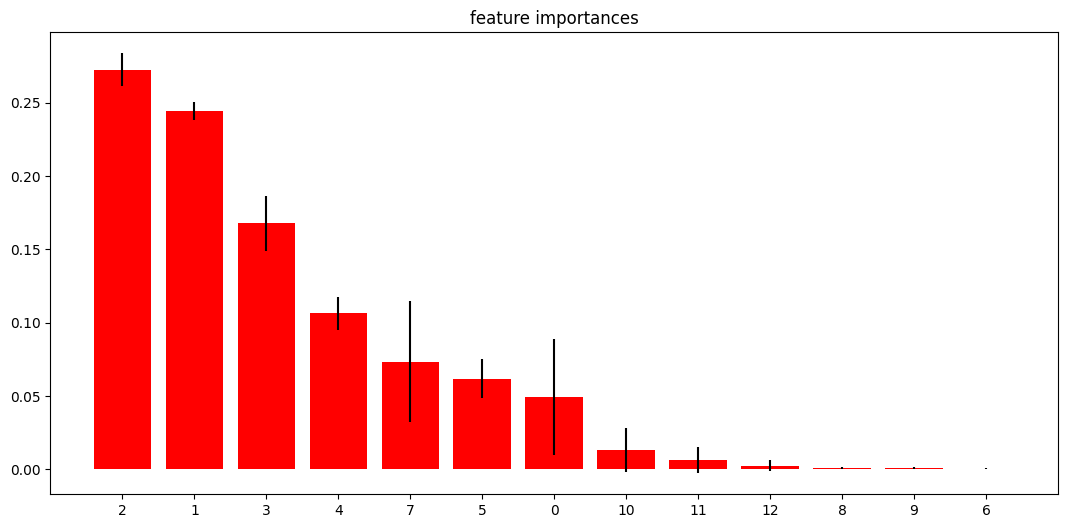

In [24]:
importances=forest.feature_importances_
std=np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices=np.argsort(importances)[::-1]  # índice é a importância das árvores ornada pelo maior valor

# print the feature ranking
print('Feature ranking')
df=pd.DataFrame()
for i, j in zip(x_train_n,forest.feature_importances_): # zip é pra arrumar as colunas com os valores
    aux=pd.DataFrame({'feature':i,'importance':j},index=[0])
    df=pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

# plot the imputiry-based feature importances of the forest
plt.figure()
plt.title('feature importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

# **Step 7 Machine learning**

In [14]:
df7=df5.copy()

In [15]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df7[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation

## **7.1 Logistic regression**

Precision at 20% 0.28708637589632263 

Precision at 50% 0.196316120906801 

Recall at 20% 0.5827991452991453 

Recall at 50% 0.999198717948718 



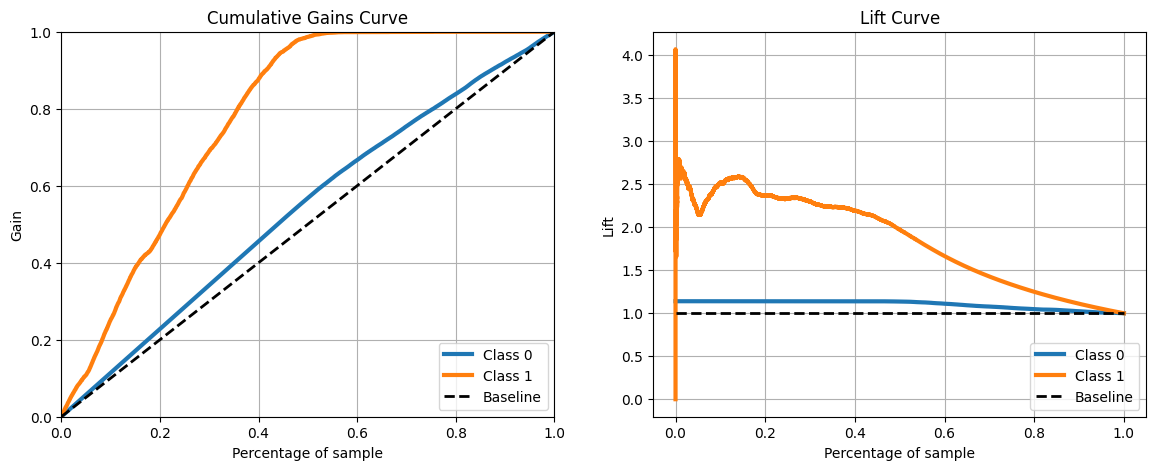

In [48]:
# model definition
lr=lm.LogisticRegression(random_state=42)

# model training
lr.fit(x_train,y_train)

# model prediction
yhat_lr=lr.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lr, data = precision_at_k( df, k=15200 )
precision_at_50_lr, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_lr}','\n')
print(f'Precision at 50% {precision_at_50_lr}','\n')

# compute recall at k
recall_at_20_lr, data = recall_at_k( df, k=15200 )
recall_at_50_lr, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_lr}','\n')
print(f'Recall at 50% {recall_at_50_lr}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lr,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lr,ax=ax2 );

### 7.1.1 Logistic regression - Cross validation

Precision at 20% 0.2839736967252095 

Precision at 50% 0.19456197317065171 

Recall at 20% 0.5830836055086029 

Recall at 50% 0.9986868244722045 



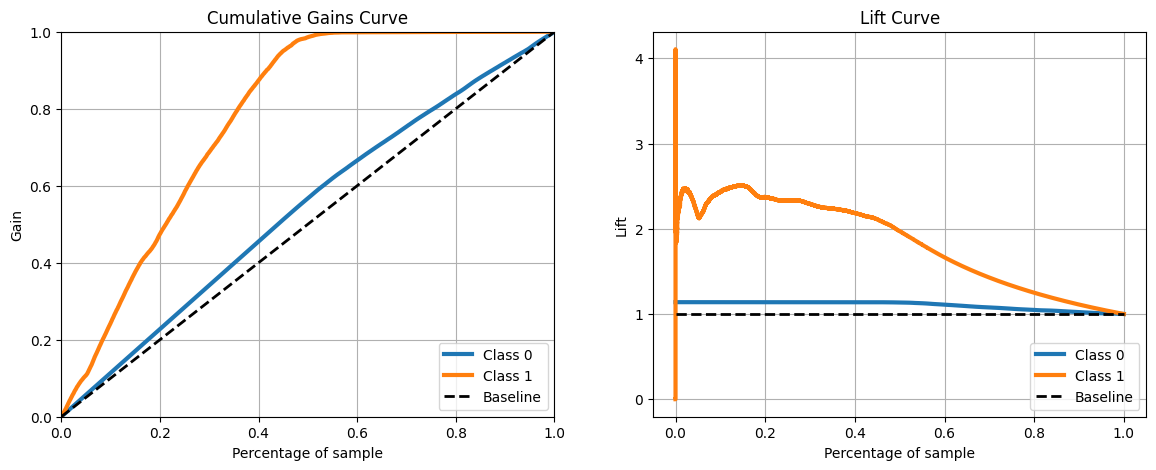

In [49]:
lr_cv = cross_val_predict(lr, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = lr_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lrcv, data = precision_at_k( df, k=60980 )
precision_at_50_lrcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_lrcv}','\n')
print(f'Precision at 50% {precision_at_50_lrcv}','\n')

# compute recall at k
recall_at_20_lrcv, data = recall_at_k( df, k=60980 )
recall_at_50_lrcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_lrcv}','\n')
print(f'Recall at 50% {recall_at_50_lrcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,lr_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, lr_cv,ax=ax2 );

## **7.2 Knn**

Precision at 20% 0.2814288533649102 

Precision at 50% 0.1705237195633921 

Recall at 20% 0.5713141025641025 

Recall at 50% 0.8679220085470085 



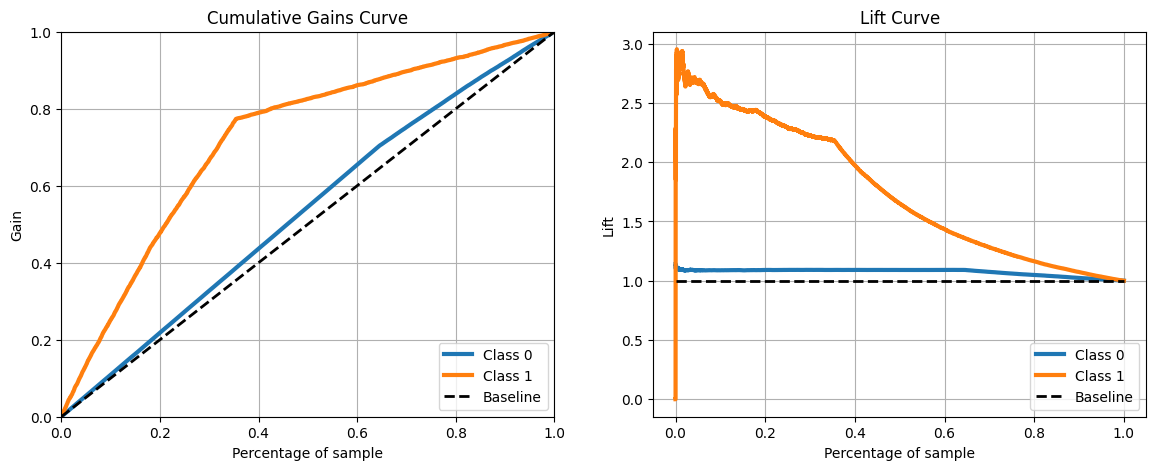

In [50]:
# model definition
knn=nh.KNeighborsClassifier(n_jobs=-1)

# model training
knn.fit(x_train,y_train)

# model prediction
yhat_knn=knn.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_knn, data = precision_at_k( df, k=15200 )
precision_at_50_knn, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_knn}','\n')
print(f'Precision at 50% {precision_at_50_knn}','\n')

# compute recall at k
recall_at_20_knn, data = recall_at_k( df, k=15200 )
recall_at_50_knn, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_knn}','\n')
print(f'Recall at 50% {recall_at_50_knn}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_knn,ax=ax2 );

### 7.2.1 KNN - Cross validation

Precision at 20% 0.27952968957544155 

Precision at 50% 0.17019252845288466 

Recall at 20% 0.5739587191487929 

Recall at 50% 0.8735984376578336 



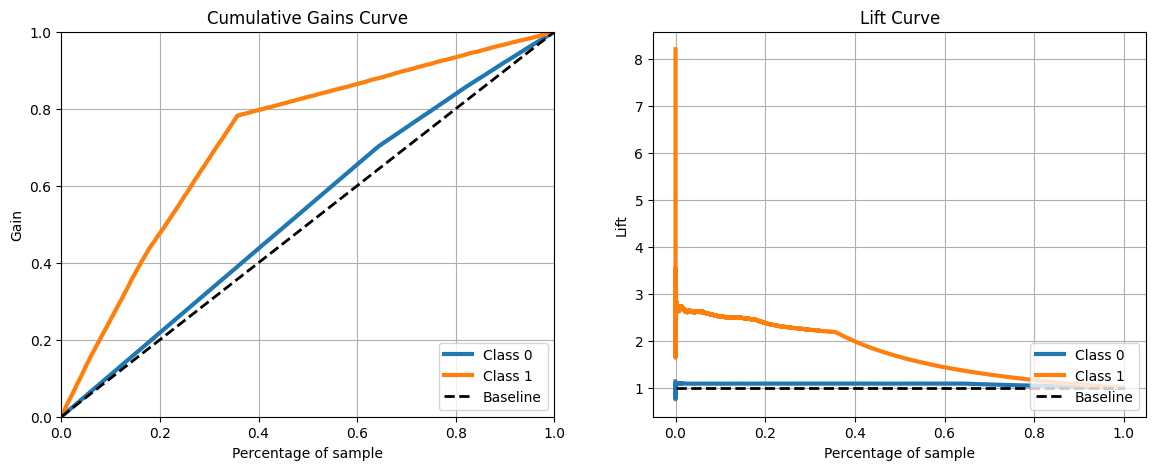

In [51]:
#
knn_cv = cross_val_predict(knn, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = knn_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_knncv, data = precision_at_k( df, k=60980 )
precision_at_50_knncv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_knncv}','\n')
print(f'Precision at 50% {precision_at_50_knncv}','\n')

# compute recall at k
recall_at_20_knncv, data = recall_at_k( df, k=60980 )
recall_at_50_knncv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_knncv}','\n')
print(f'Recall at 50% {recall_at_50_knncv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,knn_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, knn_cv,ax=ax2 );

## **7.3 Extra trees**

Precision at 20% 0.3020196039734228 

Precision at 50% 0.1934823677581864 

Recall at 20% 0.6131143162393162 

Recall at 50% 0.9847756410256411 



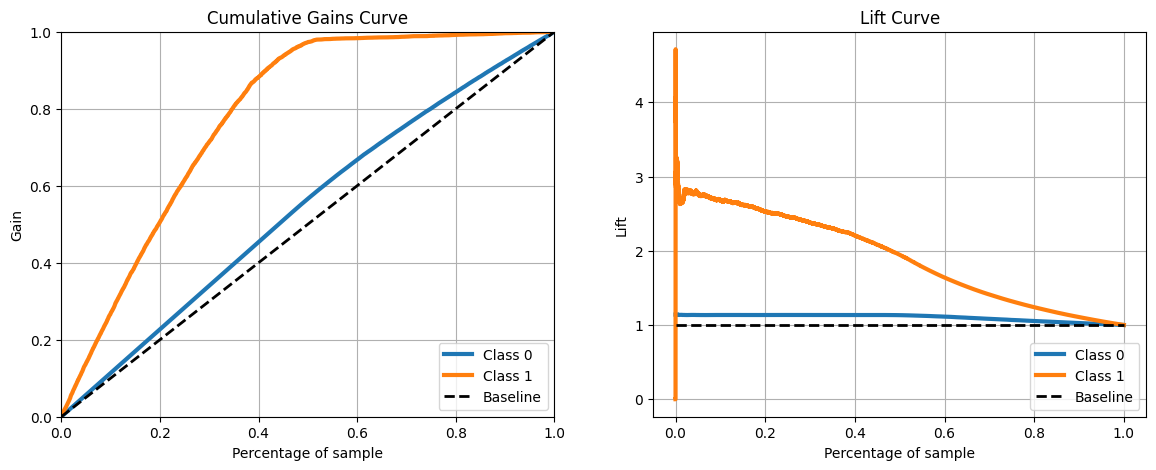

In [52]:
# model definition
et=en.ExtraTreesClassifier(n_jobs=-1,random_state=42)

# model training
et.fit(x_train,y_train)

# model prediction
yhat_et=et.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_et, data = precision_at_k( df, k=15200 )
precision_at_50_et, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_et}','\n')
print(f'Precision at 50% {precision_at_50_et}','\n')

# compute recall at k
recall_at_20_et, data = recall_at_k( df, k=15200 )
recall_at_50_et, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_et}','\n')
print(f'Recall at 50% {recall_at_50_et}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_et,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_et,ax=ax2 );

### 7.3.1 Extra tress - Cross validation

Precision at 20% 0.29930634131942735 

Precision at 50% 0.19208895011315558 

Recall at 20% 0.6145661470083168 

Recall at 50% 0.9859927943701808 



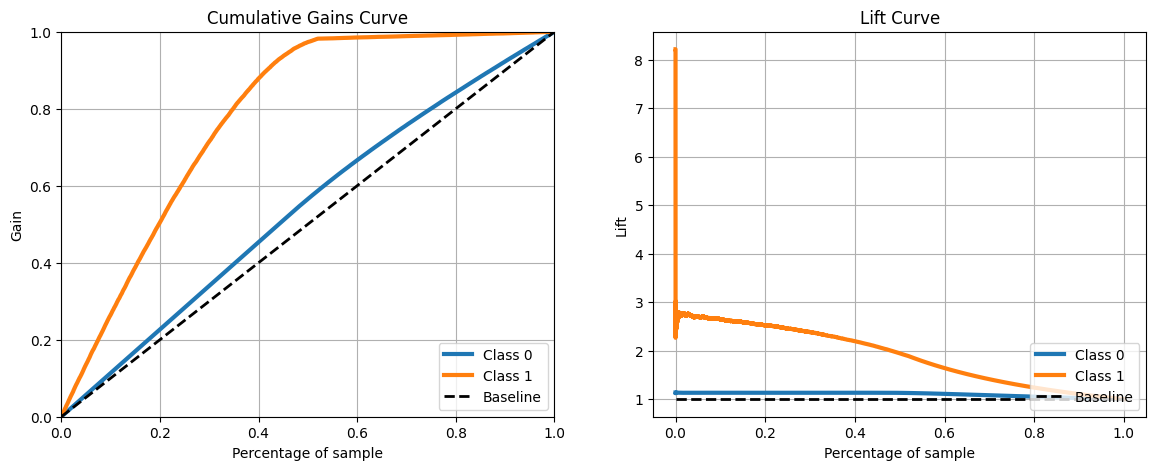

In [53]:
#
et_cv = cross_val_predict(et, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = et_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_etcv, data = precision_at_k( df, k=60980 )
precision_at_50_etcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_etcv}','\n')
print(f'Precision at 50% {precision_at_50_etcv}','\n')

# compute recall at k
recall_at_20_etcv, data = recall_at_k( df, k=60980 )
recall_at_50_etcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_etcv}','\n')
print(f'Recall at 50% {recall_at_50_etcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,et_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, et_cv,ax=ax2 );

## 7.4 Random forest

Precision at 20% 0.3081376225248339 

Precision at 50% 0.19508291351805207 

Recall at 20% 0.625534188034188 

Recall at 50% 0.9929220085470085 



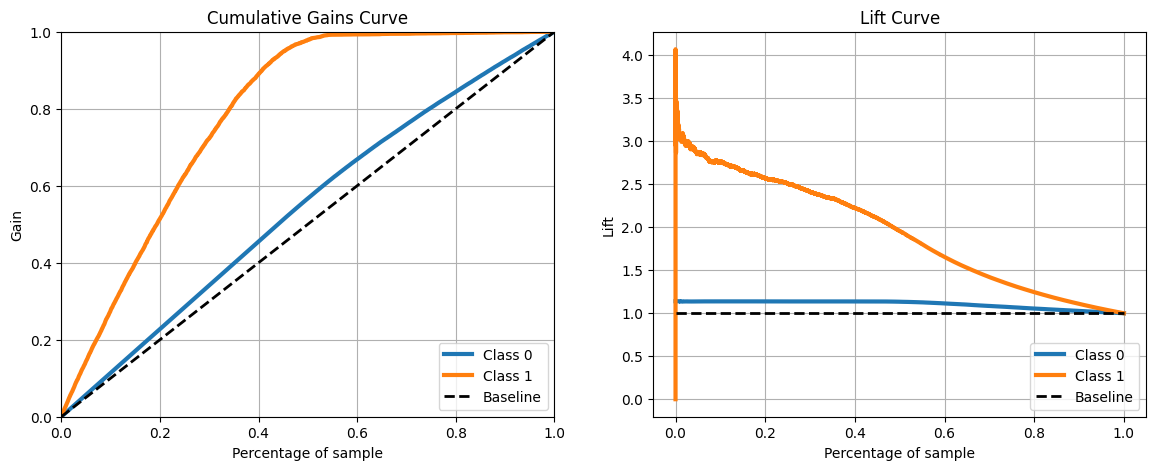

In [54]:
# model definition
rf = en.RandomForestClassifier(n_jobs=-1, random_state=42) 

# model training
rf.fit(x_train,y_train)

# model prediction
yhat_rf=rf.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_rf, data = precision_at_k( df, k=15200 )
precision_at_50_rf, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_rf}','\n')
print(f'Precision at 50% {precision_at_50_rf}','\n')

# compute recall at k
recall_at_20_rf, data = recall_at_k( df, k=15200 )
recall_at_50_rf, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_rf}','\n')
print(f'Recall at 50% {recall_at_50_rf}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_rf,ax=ax2 );

### 7.4.1 Random forest - Cross validation

Precision at 20% 0.3045374788868664 

Precision at 50% 0.19341401817048773 

Recall at 20% 0.6253072494023367 

Recall at 50% 0.9927943701808142 



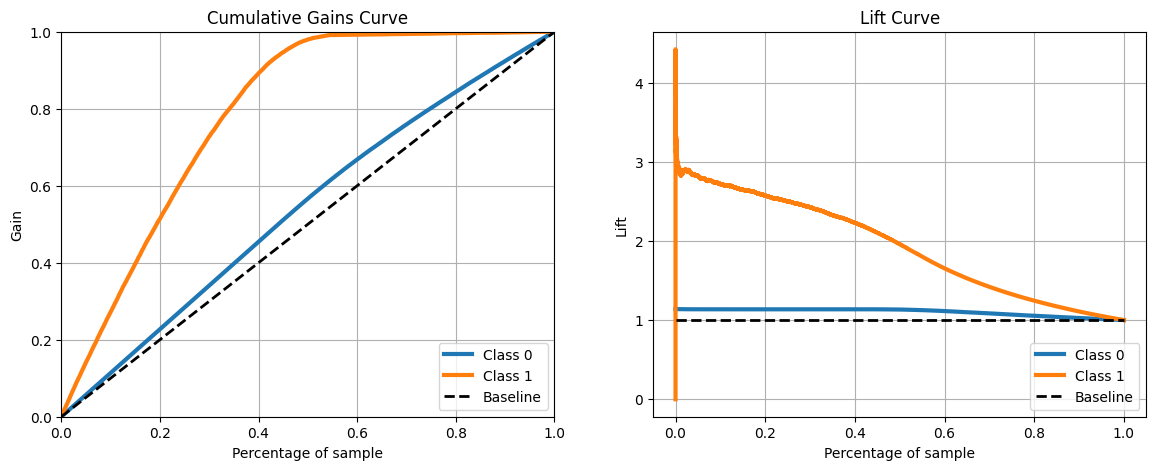

In [55]:
#
rf_cv = cross_val_predict(rf, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = rf_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_rfcv, data = precision_at_k( df, k=60980 )
precision_at_50_rfcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_rfcv}','\n')
print(f'Precision at 50% {precision_at_50_rfcv}','\n')

# compute recall at k
recall_at_20_rfcv, data = recall_at_k( df, k=60980 )
recall_at_50_rfcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_rfcv}','\n')
print(f'Recall at 50% {recall_at_50_rfcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,rf_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, rf_cv,ax=ax2 );

## **7.5 XGB Classifier**

Precision at 20% 0.33157868844394156 

Precision at 50% 0.19454229394207748 

Recall at 20% 0.6764155982905983 

Recall at 50% 0.9987980769230769 



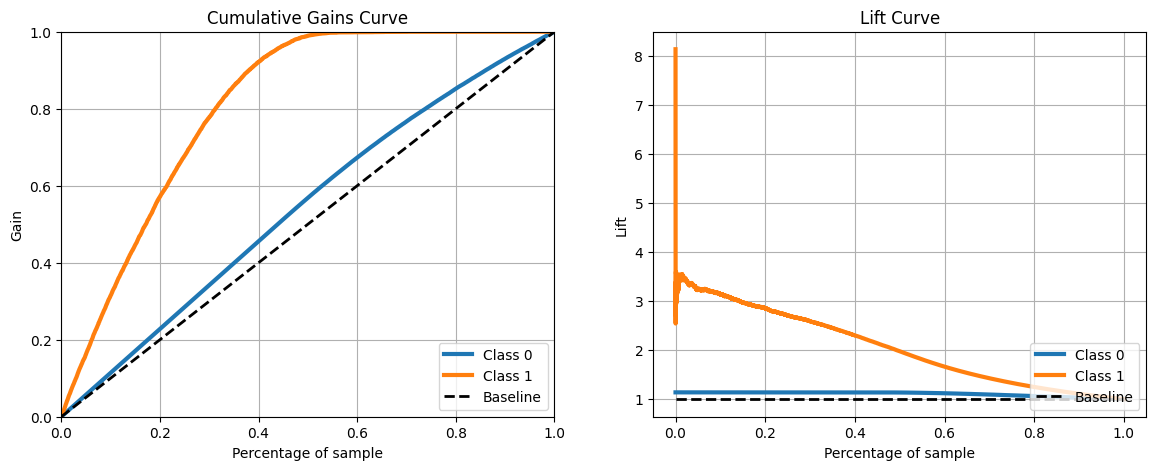

In [56]:
# model definition
xgb_model = xgb.XGBClassifier(n_jobs=-1, random_state=42) 

# model training
xgb_model.fit(x_train,y_train)

# model prediction
yhat_xgb=xgb_model.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_xgb, data = precision_at_k( df, k=15200 )
precision_at_50_xgb, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20_xgb, data = recall_at_k( df, k=15200 )
recall_at_50_xgb, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_xgb}','\n')
print(f'Recall at 50% {recall_at_50_xgb}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_xgb,ax=ax2 );

### **7.6.1 XGB Classifier - Cross validation**

Precision at 20% 0.32982404355454975 

Precision at 50% 0.19456853291350978 

Recall at 20% 0.67722818950133 

Recall at 50% 0.9987204956395839 



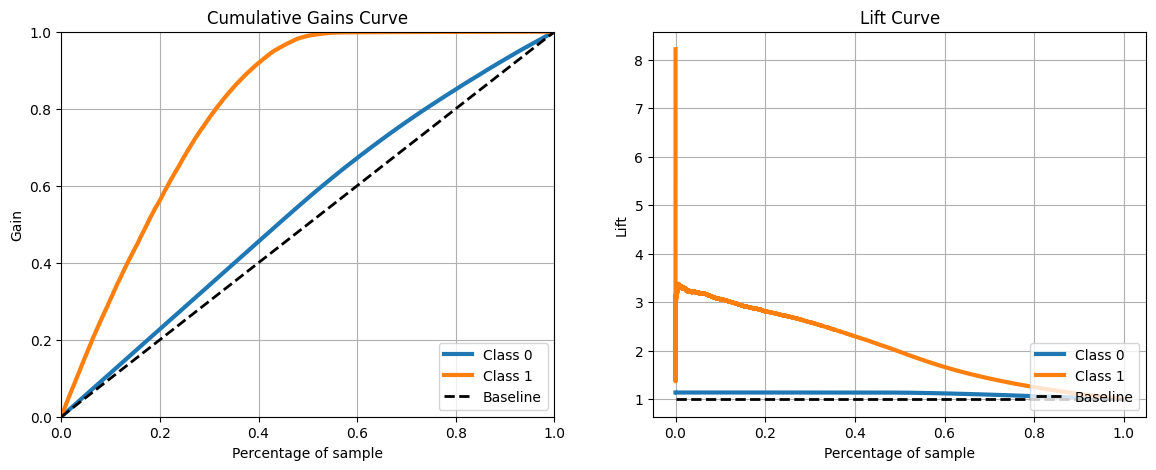

In [57]:
#
xgb_cv = cross_val_predict(xgb_model, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = xgb_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_xgbcv, data = precision_at_k( df, k=60980 )
precision_at_50_xgbcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_xgbcv}','\n')
print(f'Precision at 50% {precision_at_50_xgbcv}','\n')

# compute recall at k
recall_at_20_xgbcv, data = recall_at_k( df, k=60980 )
recall_at_50_xgbcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_xgbcv}','\n')
print(f'Recall at 50% {recall_at_50_xgbcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,xgb_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, xgb_cv,ax=ax2 );

## **7.7 LGBM Classifier**

Precision at 20% 0.33524110255904216 

Precision at 50% 0.196316120906801 

Recall at 20% 0.6805555555555556 

Recall at 50% 0.999198717948718 



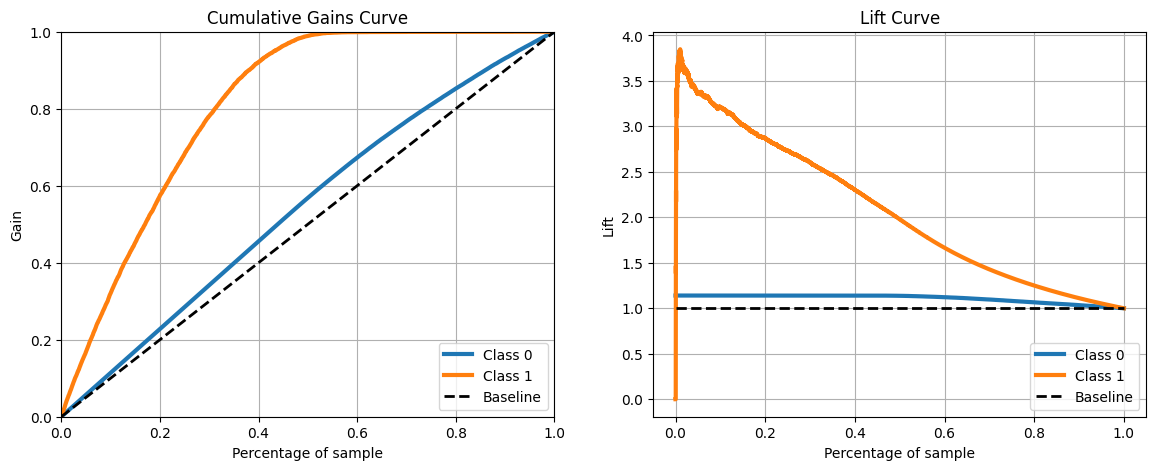

In [58]:
# model definition
lgbm = lightgbm.LGBMClassifier(n_jobs=-1,random_state=42) 

# model training
lgbm.fit(x_train,y_train)

# model prediction
yhat_lgbm=lgbm.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lgbm, data = precision_at_k( df, k=15200 )
precision_at_50_lgbm, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_lgbm}','\n')
print(f'Precision at 50% {precision_at_50_lgbm}','\n')

# compute recall at k
recall_at_20_lgbm, data = recall_at_k( df, k=15200 )
recall_at_50_lgbm, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_lgbm}','\n')
print(f'Recall at 50% {recall_at_50_lgbm}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lgbm,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm,ax=ax2 );

### **7.7.1 LGBM Classifier - Cross validation** 

Precision at 20% 0.33157868844394156 

Precision at 50% 0.19454229394207748 

Recall at 20% 0.6808310044109229 

Recall at 50% 0.9985858109700664 



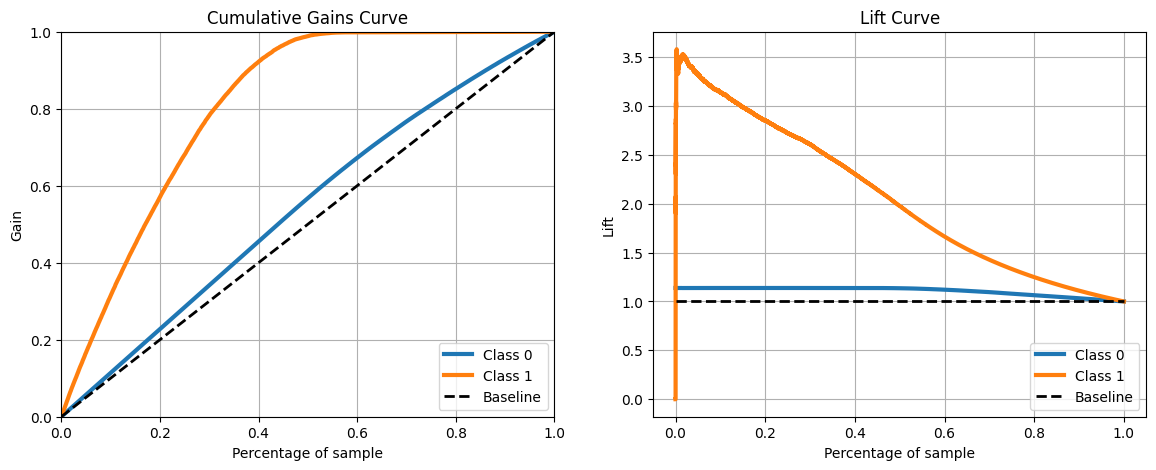

In [59]:
lgbm_cv = cross_val_predict(lgbm, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = lgbm_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lgbmcv, data = precision_at_k( df, k=60980 )
precision_at_50_lgbmcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_lgbmcv}','\n')
print(f'Precision at 50% {precision_at_50_lgbmcv}','\n')

# compute recall at k
recall_at_20_lgbmcv, data = recall_at_k( df, k=60980 )
recall_at_50_lgbmcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_lgbmcv}','\n')
print(f'Recall at 50% {recall_at_50_lgbmcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,lgbm_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, lgbm_cv,ax=ax2 );

## 7.8 Compare performances

In [70]:
res=np.array([[precision_at_20_lgbm,precision_at_50_lgbm,recall_at_20_lgbm,recall_at_50_lgbm],
            [precision_at_20_xgb, precision_at_50_xgb, recall_at_20_xgb, recall_at_50_xgb],
            [precision_at_20_rf,  precision_at_50_rf,  recall_at_20_rf,  recall_at_50_rf],
            [precision_at_20_et,  precision_at_50_et,  recall_at_20_et,  recall_at_50_et],
            [precision_at_20_knn, precision_at_50_knn, recall_at_20_knn,  recall_at_50_knn],
            [precision_at_20_lr,  precision_at_50_lr,  recall_at_20_lr,  recall_at_50_lr]])

results=pd.DataFrame(res,columns=['precision_at_20_','precision_at_50_','recall_at_20_','recall_at_50_'],
                 index=['LGBM','XGB','RF','ET','KNN','LR'])
results

,precision_at_20_,precision_at_50_,recall_at_20_,recall_at_50_
LGBM,0.335241,0.196316,0.680556,0.999199
XGB,0.333202,0.196237,0.676416,0.998798
RF,0.308138,0.195083,0.625534,0.992922
ET,0.302020,0.193482,0.613114,0.984776
KNN,0.281429,0.170524,0.571314,0.867922
LR,0.287086,0.196316,0.582799,0.999199


### 7.8.1 Compare cross validation performances

In [72]:
cv_res=np.array([[precision_at_20_lgbmcv,precision_at_50_lgbmcv,recall_at_20_lgbmcv,recall_at_50_lgbmcv],
            [precision_at_20_xgbcv, precision_at_50_xgbcv, recall_at_20_xgbcv, recall_at_50_xgbcv],
            [precision_at_20_rfcv,  precision_at_50_rfcv,  recall_at_20_rfcv,  recall_at_50_rfcv],
            [precision_at_20_etcv,  precision_at_50_etcv,  recall_at_20_etcv,  recall_at_50_etcv],
            [precision_at_20_knncv, precision_at_50_knncv, recall_at_20_knncv,  recall_at_50_knncv],
            [precision_at_20_lrcv,  precision_at_50_lrcv,  recall_at_20_lrcv,  recall_at_50_lrcv]])

cv_results=pd.DataFrame(cv_res,columns=['precision_at_20_cv','precision_at_50_cv','recall_at_20_cv','recall_at_50_cv'],
                 index=['LGBM','XGB','RF','ET','KNN','LR'])

In [89]:
print('Best precision at 20%')
cv_results.sort_values(by=['precision_at_20_cv'],ascending=False)

Best precision at 20%


,precision_at_20_cv,precision_at_50_cv,recall_at_20_cv,recall_at_50_cv
LGBM,0.331579,0.194542,0.680831,0.998586
XGB,0.329824,0.194569,0.677228,0.998720
RF,0.304537,0.193414,0.625307,0.992794
ET,0.299306,0.192089,0.614566,0.985993
LR,0.283974,0.194562,0.583084,0.998687
KNN,0.279530,0.170193,0.573959,0.873598


In [91]:
print('Best precision at 50%')
cv_results.sort_values(by=['precision_at_50_cv'],ascending=False)

Best precision at 50%


,precision_at_20_cv,precision_at_50_cv,recall_at_20_cv,recall_at_50_cv
XGB,0.329824,0.194569,0.677228,0.998720
LR,0.283974,0.194562,0.583084,0.998687
LGBM,0.331579,0.194542,0.680831,0.998586
RF,0.304537,0.193414,0.625307,0.992794
ET,0.299306,0.192089,0.614566,0.985993
KNN,0.279530,0.170193,0.573959,0.873598


In [90]:
print('Best recall at 20%')
cv_results.sort_values(by=['recall_at_20_cv'],ascending=False)

Best recall at 20%


,precision_at_20_cv,precision_at_50_cv,recall_at_20_cv,recall_at_50_cv
LGBM,0.331579,0.194542,0.680831,0.998586
XGB,0.329824,0.194569,0.677228,0.998720
RF,0.304537,0.193414,0.625307,0.992794
ET,0.299306,0.192089,0.614566,0.985993
LR,0.283974,0.194562,0.583084,0.998687
KNN,0.279530,0.170193,0.573959,0.873598


In [92]:
print('Best recall at 50%')
cv_results.sort_values(by=['recall_at_50_cv'],ascending=False)

Best recall at 50%


,precision_at_20_cv,precision_at_50_cv,recall_at_20_cv,recall_at_50_cv
XGB,0.329824,0.194569,0.677228,0.998720
LR,0.283974,0.194562,0.583084,0.998687
LGBM,0.331579,0.194542,0.680831,0.998586
RF,0.304537,0.193414,0.625307,0.992794
ET,0.299306,0.192089,0.614566,0.985993
KNN,0.279530,0.170193,0.573959,0.873598


# **Step 8 Final model**

## 8.1 Hyperparameter fine tuning + cross validation

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
              precision    recall  f1-score   support

           0     0.8772    1.0000    0.9346     53490
           1     0.0000    0.0000    0.0000      7488

    accuracy                         0.8772     60978
   macro avg     0.4386    0.5000    0.4673     60978
weighted avg     0.7695    0.8772    0.8198     60978

Precision at 20% 0.33530688770475625 

Precision at 50% 0.19634235936188077 

Recall at 20% 0.6806891025641025 

Recall at 50% 0.9993322649572649 

Top k accuracy_score 1.0


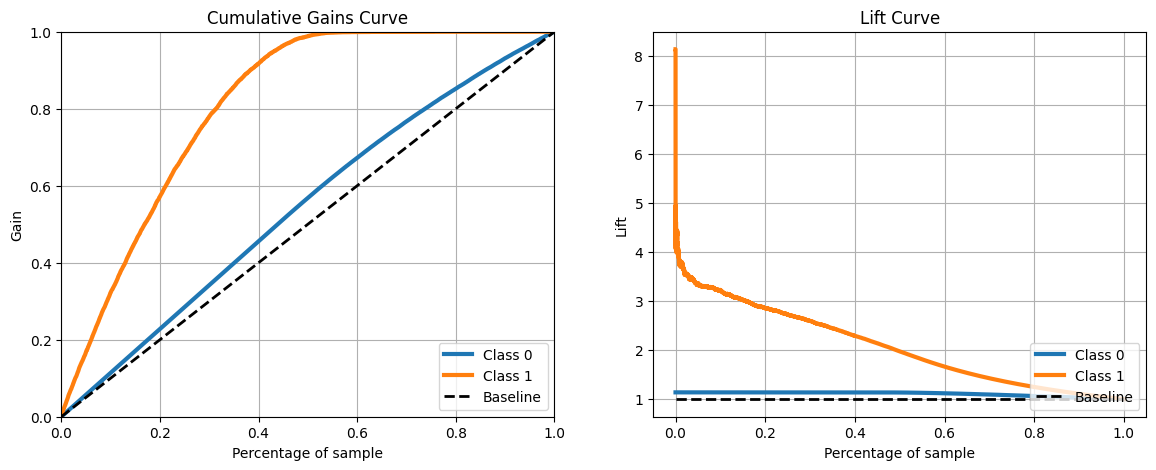

In [130]:
lgbm = lightgbm.LGBMClassifier(n_jobs=-1,random_state=42, verbose=-2) 


params={'learning_rate': [0.1,0.3],
        'max_depth':[3,12],
        'num_leaves':[40,100],
        'min_data_in_leaf':[50,100]}


lgbm = GridSearchCV(lgbm, param_grid=params,cv=5,n_jobs=-1,verbose=-2)
lgbm.fit(x_train, y_train)
       
print(lgbm.best_params_)    

# model prediction
yhat_lgbm=lgbm.predict_proba(x_val);

df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=15200 )
precision_at_50, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=15200 )
recall_at_50, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_lgbm2, k=2)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lgbm,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm,ax=ax2 );

## 8.2 Test preparation

In [135]:
x_test=pd.concat ([x_test, y_test], axis=1) 


x_test['vehicle_age']=x_test['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' 
                                            else 'between_1_2_years' if x == '1-2 Year'
                                            else 'below_1_year')

x_test['previously_insured']=x_test['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

x_test['driving_license']=x_test['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')


ss=pp.StandardScaler()
x_test['annual_premium'] = ss.fit_transform(x_test[['annual_premium']].values)

mms_age=pp.MinMaxScaler()
x_test['age']=mms_age.fit_transform(x_test[['age']].values)

mms_vintage=pp.MinMaxScaler()
x_test['vintage']=mms_vintage.fit_transform(x_test[['vintage']].values)


x_test=pd.get_dummies(x_test,prefix='gender',columns=['gender'])

target_encode_region_code=x_test.groupby('region_code')['response'].mean()
x_test['region_code']=x_test['region_code'].map(target_encode_region_code)  

x_test=pd.get_dummies(x_test,prefix='vehicle_age',columns=['vehicle_age'])

fe_policy_sales_channel=x_test.groupby('policy_sales_channel').size()/len(x_test) 
x_test['policy_sales_channel']=x_test['policy_sales_channel'].map(fe_policy_sales_channel)

x_test['previously_insured']=x_test['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)

x_test['driving_license']=x_test['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)

x_test['vehicle_damage']=x_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

X_test=x_test.fillna(0)

X_test=x_test[cols_selected]

y_test=x_test['response']

## 8.3 Final model

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Precision at 20% 0.3602492620531322 

Precision at 50% 0.24679890848026867 

Recall at 20% 0.5767090202667227 

Recall at 50% 0.9877139556862333 



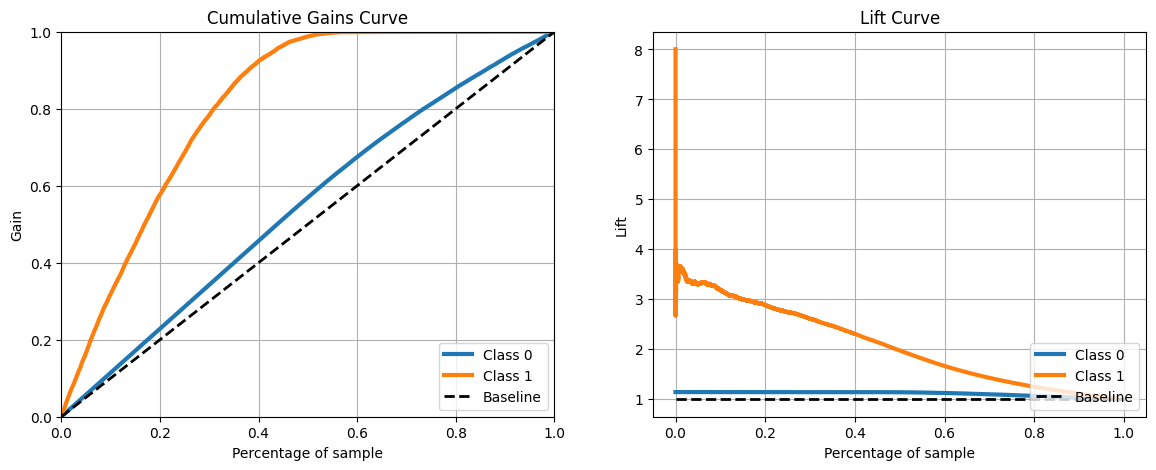

In [158]:
train=pd.concat ([x_train, y_train], axis=1) 

validation=pd.concat ([x_validation, y_validation], axis=1) 

full = pd.merge(train, validation,how='outer')
full_x=full[cols_selected]
full_y=full['response']


# model definition
lgbm_final = lightgbm.LGBMClassifier(learning_rate=0.1, max_depth=3,
                               min_data_in_leaf=50, num_leaves=40, n_jobs=-1, random_state=42,
                                    verbose=-1) 

# model training
lgbm_final.fit(full_x,full_y)

# model prediction
yhat_lgbm_final=lgbm_final.predict_proba(X_test);


df = X_test.copy()
df['response'] = y_test.copy()

# propensity score
df['score'] = yhat_lgbm_final[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=15244 )
precision_at_50, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=15244 )
recall_at_50, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_test,yhat_lgbm_final,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve(y_test, yhat_lgbm_final,ax=ax2);